# Fig3: OneK1K cis + trans

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import matplotlib.colors as mcolors
from scipy import stats
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from cigma import plot

In [2]:
# Load data
meta_f  = '../../data/Yazar2022Science/gene_meta.txt'
cis_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/he.npy'
trans_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/trans/he.jk.npy'
jk_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/he.free.jk.npy'
P_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/P.final.gz'

meta = pd.read_table(meta_f, usecols=['feature', 'GeneSymbol', 'chr', 'start']).drop_duplicates()
cis = np.load(cis_f, allow_pickle=True).item()
trans = np.load(trans_f, allow_pickle=True).item()
jk = np.load(jk_f, allow_pickle=True).item()
P = pd.read_table(P_f, index_col=0)
cts = P.columns.to_list()

In [3]:
print(jk.keys())
print(jk['p']['free'].keys())
print(jk['gene'][:5])
print(P.columns)
p_cut = 0.05 / len(jk['gene'])
print((jk['p']['free']['V'] < p_cut).sum())
print((jk['p']['free']['hom_g2'] < p_cut).sum())
print(trans['free'].keys())

dict_keys(['gene', 'free', 'p'])
dict_keys(['hom_g2', 'V', 'hom_e2', 'W', 'var_hom_g2', 'var_V', 'var_hom_e2', 'var_W', 'var_shared_h2', 'var_specific_h2', 'var_specificity', 'jk_hom_g2', 'jk_V', 'jk_hom_e2', 'jk_W', 'jk_shared_h2', 'jk_specific_h2', 'ct_beta'])
['ENSG00000225880' 'ENSG00000230368' 'ENSG00000188976' 'ENSG00000187961'
 'ENSG00000188290']
Index(['B IN', 'B Mem', 'CD4 ET', 'CD4 NC', 'CD8 ET', 'CD8 NC', 'NK'], dtype='object')
193
402
dict_keys(['hom_g2', 'hom_e2', 'V', 'W', 'hom_g2_b', 'V_b', 'shared_h2', 'specific_h2', 'shared_h2_b', 'specific_h2_b', 'shared_h2_total', 'specific_h2_total', 'r2', 'ctnu', 'nu', 'beta', 'ct_beta', 'op_fixed_vars', 'op_random_vars'])


In [4]:
# add v bar and w bar
# trans['free']['v_bar'] = np.diagonal(trans['free']['V'], axis1=1, axis2=2).mean(axis=1)
# trans['free']['v_bar_b'] = np.diagonal(trans['free']['V_b'], axis1=1, axis2=2).mean(axis=1)

In [5]:
# jk
# Cumulate BP
def cumulate_bp(data):
    data_grouped = data.groupby(('chr'))
    cumulative_bp = 0
    ticks = []
    new_data = []
    for chrom, group in data_grouped:
        group['start_cum'] = group['start'] + cumulative_bp
        ticks.append(group['start_cum'].median())
        cumulative_bp = group['start_cum'].max()
        new_data.append(group)
    combined_data = pd.concat(new_data)
    return combined_data, ticks

jk_data = pd.DataFrame({'feature': jk['gene'], 'V': -np.log10(jk['p']['free']['V']), 'W': -np.log10(jk['p']['free']['W']),
                        'v_bar': np.diagonal(jk['free']['V'], axis1=1, axis2=2).mean(axis=1),
                        'specific_h2': jk['free']['specific_h2'],
                        'raw_p_beta': jk['p']['free']['ct_beta'], 
                        'var_beta': np.var(jk['free']['ct_beta'], axis=1)})
# sanity check
# assert np.array_equal(jk['gene'], iid_jk['gene'])

jk_data = meta.merge(jk_data).sort_values(['chr', 'start'])
jk_data, chr_ticks = cumulate_bp(jk_data)

jk_data['W'] = np.clip(jk_data['W'], 0, 100)

In [6]:
# Full
full_V_diag = np.diagonal(cis['full']['V'], axis1=1, axis2=2)
full_W_diag = np.diagonal(cis['full']['W'], axis1=1, axis2=2)
# NOTE: ratio of means
full_V = cis['full']['V']
full_W = cis['full']['W']
full_V_mean = np.mean(full_V, axis=0)
full_W_mean = np.mean(full_W, axis=0)

full_h2 = np.diag(full_V_mean) / np.diag(full_V_mean + full_W_mean)
full_V_cor = full_V_mean / np.sqrt(np.outer(np.diag(full_V_mean), np.diag(full_V_mean)))
full_W_cor = full_W_mean / np.sqrt(np.outer(np.diag(full_W_mean), np.diag(full_W_mean)))
full_cor = full_V_cor.copy()
upper_mask = np.triu(np.ones_like(full_cor, dtype=bool))
full_cor[upper_mask] = full_W_cor[upper_mask]
np.fill_diagonal(full_cor, full_h2)

9065 genes after filtering
Cis shared: 0.022643939075989168; Cis specific median: 0.010226352865908495;
Cis specific (%): 0.3111123224577636
Trans shared median: 0.10136985303533792; Trans specific median: 0.14850067668957345;
Tans specific (%): 0.5943104889282522
Trans (%): 0.8837440884972985
[[0.00124157 0.00141852]
 [0.02370026 0.02043696]]
[0.02264394 0.10136985] [0.01022635 0.14850068]
trans - cis for median(specific h2) / (median(shared h2) + median(specific h2)) = 0.2831981664704886 with p = 0.0001
significance level: (0.05 / n_tests) = (0.05/10288) = 4.86e-06
Index(['feature', 'GeneSymbol', 'chr', 'start', 'V', 'W', 'v_bar',
       'specific_h2', 'raw_p_beta', 'var_beta', 'start_cum'],
      dtype='object') (193, 11) (97, 11) (1912, 11)
               feature GeneSymbol  chr      start         V          W  \
1637   ENSG00000163599      CTLA4    2  204732509  10.15487   3.215970   
10229  ENSG00000183172      SMDT1   22   42475695  36.85511  17.513121   

          v_bar  speci

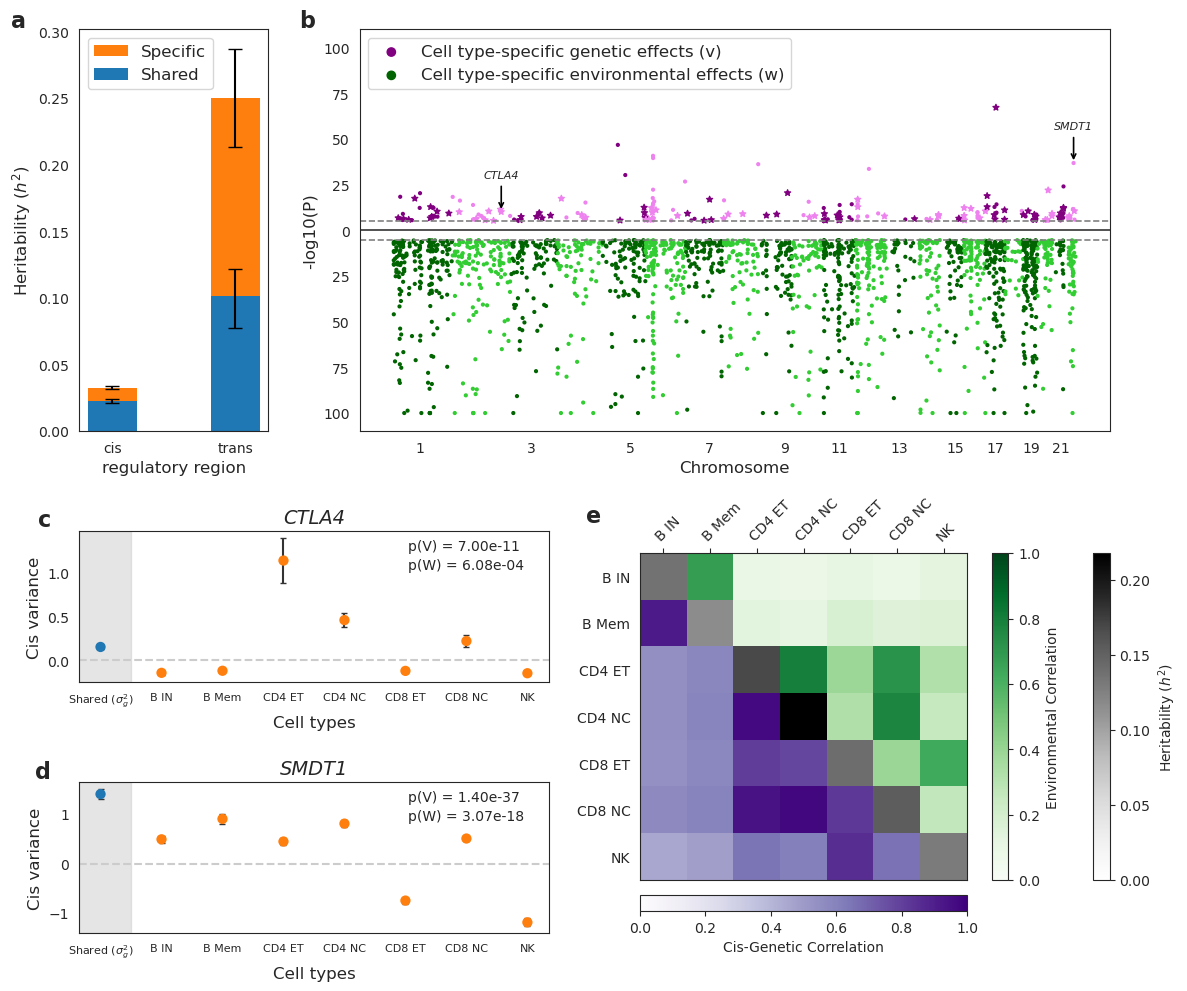

In [43]:
# fig
# colors = sns.color_palette('bright')
colors = sns.color_palette()
fs = 12
# sns.set_style('dark')

fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(4, 4, figure=fig)

# axis1: cis Transcriptome-wide + Trans transcriptome-wide
ax = fig.add_subplot(gs[:2, 0])
dif, p = plot.ctp_h2_plot(trans, ax, colors, h2='median', width=.4)  # NOTE: filter bio_var > 0
ax.legend(loc='upper left', reverse=True, fontsize=12)
ax.set_ylabel('Heritability ($h^2$)', fontsize=12)
ax.set_xlabel('regulatory region', fontsize=12)
plt.xticks(fontsize=10)
print(f'trans - cis for median(specific h2) / (median(shared h2) + median(specific h2)) = {dif} with p = {p}')
ax.text(-0.28, 1.05, 'a', transform=ax.transAxes, fontsize=fs + 4, fontweight='bold', va='top', ha='right')


# axis4: Full
ax = fig.add_subplot(gs[2:, 2:])
mask_diagonal = np.eye(full_cor.shape[0], dtype=bool)
mask_lower = np.tril(np.ones_like(full_cor, dtype=bool), -1)
mask_upper = np.triu(np.ones_like(full_cor, dtype=bool), 1)
cmap_diag = plt.cm.Grays
cmap_lower = plt.cm.Purples
cmap_upper = plt.cm.Greens
diagonal_img = ax.imshow(np.ma.masked_where(~mask_diagonal, full_cor), cmap=cmap_diag, interpolation='none', vmin=0)
lower_img = ax.imshow(np.ma.masked_where(~mask_lower, full_cor), cmap=cmap_lower, interpolation='none', vmin=0, vmax=1)
upper_img = ax.imshow(np.ma.masked_where(~mask_upper, full_cor), cmap=cmap_upper, interpolation='none', vmin=0, vmax=1)
divider = make_axes_locatable(ax)
cax_upper = divider.append_axes("right", size="5%", pad=0.25)
cax_diagonal = divider.append_axes("right", size="5%", pad=0.85)
cax_lower = divider.append_axes("bottom", size="5%", pad=0.15)

cbar_lower = fig.colorbar(lower_img, cax=cax_lower, orientation='horizontal')
cbar_lower.set_label('Cis-Genetic Correlation')
cbar_diag = fig.colorbar(diagonal_img, cax=cax_diagonal)
cbar_diag.set_label('Heritability ($h^2$)')
cbar_diag.set_ticks([0, 0.05, 0.1, 0.15, 0.2])
cbar_upper = fig.colorbar(upper_img, cax=cax_upper)
cbar_upper.set_label('Environmental Correlation')

ax.set_xticks(np.arange(full_cor.shape[1]))
ax.set_yticks(np.arange(full_cor.shape[0]))
ax.set_xticklabels(cts)
ax.set_yticklabels(cts)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
ax.text(-0.12, 1.15, 'e', transform=ax.transAxes, fontsize=fs + 4, fontweight='bold', va='top', ha='right')


# axis2: Significance test
ax = fig.add_subplot(gs[:2, 1:])
light_dark_green = mcolors.ListedColormap(['violet', 'purple'])
light_dark_blue = mcolors.ListedColormap(['limegreen', 'darkgreen'])
cut = -np.log10(0.05 / jk_data.shape[0])
print(f'significance level: (0.05 / n_tests) = ({0.05}/{jk_data.shape[0]}) = {0.05/jk_data.shape[0]:.2e}')
v = 'V'
w = 'W'
sig_V = jk_data.loc[jk_data[v] > cut, :]
sig_W = jk_data.loc[jk_data[w] > cut, :]
sig_V_only = jk_data.loc[(jk_data[v] > cut) & (jk_data[w] < cut), :]
print(sig_V.columns, sig_V.shape, sig_V_only.shape, sig_W.shape)
ax.scatter(sig_V['start_cum'], sig_V[v], c=sig_V['chr'] % 2, cmap=light_dark_green, s=4, label='Cell type-specific genetic effects (v)')
ax.scatter(sig_V_only['start_cum'], sig_V_only[v], c=sig_V_only['chr'] % 2, cmap=light_dark_green, marker='*', s=20)
ax.scatter(sig_W['start_cum'], -sig_W[w], c=sig_W['chr'] % 2, cmap=light_dark_blue, s=4, label='Cell type-specific environmental effects (w)')
ax.set_xticks(chr_ticks[::2])
ax.set_xticklabels(jk_data['chr'].unique()[::2])
ax.set_xlabel('Chromosome', fontsize=12)
ax.set_ylabel('-log10(P)', fontsize=12)
yticks = ax.get_yticks()
ytick_labels = [f"{abs(int(tick))}" for tick in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)
ax.axhline(0, color='0.2', lw=1.2, ls='-')
ax.axhline(cut, color='0.5', lw=1.2, ls='--')
ax.axhline(-cut, color='0.5', lw=1.2, ls='--')
ax.set_ylim(-110, 110)
ax.legend(loc='upper left', markerscale=3, fontsize=fs)
ax.text(-0.06, 1.05, 'b', transform=ax.transAxes, fontsize=fs + 4, fontweight='bold', va='top', ha='right')

###### add gene name
genenames = ['CTLA4', 'SMDT1']
sig_V_genes = sig_V.loc[sig_V['GeneSymbol'].isin(genenames), :]
print(sig_V_genes)
for index, row in sig_V_genes.iterrows():
    gene = row['feature']
    genename = row['GeneSymbol']
    ax.annotate(genename, (row['start_cum'], row[v]), (row['start_cum'], row[v]+20), fontsize=8, fontstyle='italic',
                arrowprops={'edgecolor': 'black', 'arrowstyle': '->', 'lw': 1.2},
                ha='center', va='center')

# axis4: Example cis gene or two + Example trans gene or two
genenames = ['CTLA4', 'SMDT1']
idx = ['c', 'd']
genes = meta.loc[meta['GeneSymbol'].isin(genenames), 'feature'].to_list()
# sig_V_only = sig_V_only.sort_values(v, ascending=False)
for i, ax in enumerate([fig.add_subplot(gs[2, :2]), fig.add_subplot(gs[3, :2])]):
    # gene = sig_V['feature'].to_list()[i]
    # gene = sig_V_only['feature'].to_list()[i]
    gene = genes[i]
    genename = meta.loc[meta['feature'] == gene]
    index = np.where(jk_data['feature'] == gene)[0][0]
    assert genename.shape[0] == 1
    genename = genename['GeneSymbol'].to_list()[0]
    gene_homg2 = jk['free']['hom_g2'][index]
    gene_V = np.diag(jk['free']['V'][index])
    gene_std_hom_g2 = np.sqrt(jk['p']['free']['var_hom_g2'][index])
    gene_std_V = np.sqrt(np.diag(jk['p']['free']['var_V'][index]))
    gene_p_V = 10 ** (-1 * jk_data[v][index])
    gene_p_W = 10 ** (-1 * jk_data[w][index])
    gene_df = pd.DataFrame({'variable': ['Shared'] + cts, 'value': [gene_homg2] + gene_V.tolist(), 
                        'error': [gene_std_hom_g2] + gene_std_V.tolist()})
    print(gene_df)
    sns.scatterplot(data=gene_df, palette=[colors[0]] + [colors[1]] * len(cts), x='variable', y='value', 
                    hue='variable', ax=ax, marker='o', s=55, edgecolor="none", zorder=5)
    ax.axhline(0, ls='--', color='0.8', zorder=1)
    ax.text(0.70, 0.95, f'p(V) = {gene_p_V:.2e}', ha='left', va='top', transform=ax.transAxes)
    ax.text(0.70, 0.82, f'p(W) = {gene_p_W:.2e}', ha='left', va='top', transform=ax.transAxes)
    ax.legend().set_visible(False)
    ax.set_title(f'{genename}', fontsize=14, fontstyle='italic')
    # ax.set_title(f'{genename} ({gene})', fontsize=14, fontstyle='italic')
    ax.set_xlabel('Cell types', fontsize=fs)
    ax.set_ylabel('Cis variance', fontsize=fs)
    ax.errorbar(gene_df['variable'], gene_df['value'], yerr=gene_df['error'], 
                    fmt='none', ecolor='0.2', capsize=2, zorder=1)
    ax.text(-0.06, 1.15, idx[i], transform=ax.transAxes, fontsize=fs + 4, fontweight='bold', va='top', ha='right')


    # update labels
    current_labels = ax.get_xticklabels()
    new_labels = []
    for label in current_labels:
        label = label.get_text()
        if label == 'Shared':
            new_labels.append(r'Shared ($\sigma_g^2$)')
        else:
            # label = re.sub(' ', '\ ', label)
            # new_labels.append(f"$V_{{{label}}}$")
            new_labels.append(f"{label}")
    ax.set_xticks(ticks=range(len(current_labels)), labels=new_labels, fontsize=8)

    # add shared background
    xmin, xmax = ax.get_xlim()
    ax.axvspan(xmin, 0.5, color='0.8', alpha=0.5, zorder=0)
    ax.set_xlim((xmin, xmax))


fig.tight_layout(w_pad=2)
# fig.savefig('../../fig3.png', dpi=300)

In [8]:
def collect(cigma, trans=True):
    '''For JK'''
    out = {'gene': cigma['gene']}
    # shared genetic effect
    out['hom_g2'] = cigma['free']['hom_g2']
    out['hom_e2'] = cigma['free']['hom_e2']
    out['hom_g2_p'] = cigma['p']['free']['hom_g2']

    # specific genetic effect
    V = np.diagonal(cigma['free']['V'], axis1=1, axis2=2)
    out['V_bar'] = np.mean(V, axis=1)
    out['V_p'] = cigma['p']['free']['V']
    # out['specificity'] = out['V_bar'] / (out['V_bar'] + out['hom_g2'])
    # out['std_specificity'] = np.sqrt(cigma['p']['free']['var_specificity'])

    # specific env effect
    W = np.diagonal(cigma['free']['W'], axis1=1, axis2=2)
    out['W_bar'] = np.mean(W, axis=1)

    # h2
    out['shared_h2'] = cigma['free']['shared_h2']
    out['specific_h2'] = cigma['free']['specific_h2']
    out['std_shared_h2'] = np.sqrt(cigma['p']['free']['var_shared_h2'])
    out['std_specific_h2'] = np.sqrt(cigma['p']['free']['var_specific_h2'])

    # bio var
    if trans:
        out['hom_g2_b'] = cigma['free']['hom_g2_b']
        V_b = np.diagonal(cigma['free']['V_b'], axis1=1, axis2=2)
        out['V_b_bar'] = np.mean(V_b, axis=1)
        out['bio_var'] = out['hom_g2'] + out['V_bar'] + out['hom_g2_b'] + out['V_b_bar'] + out['hom_e2'] + out['W_bar']
        out['shared_h2_b'] = out['hom_g2_b'] / out['bio_var']
        out['specific_h2_b'] = out['V_b_bar'] / out['bio_var']
        # out['specificity_b'] = out['V_b_bar'] / (out['V_b_bar'] + out['hom_g2_b'])
        out['std_shared_h2_b'] = np.sqrt(cigma['p']['free']['var_shared_h2_b'])
        out['std_specific_h2_b'] = np.sqrt(cigma['p']['free']['var_specific_h2_b'])
        # out['std_specificity_b'] = np.sqrt(cigma['p']['free']['var_specificity_b'])
    else:
        out['bio_var'] = out['hom_g2'] + out['V_bar'] + out['hom_e2'] + out['W_bar']

    return pd.DataFrame(out)

# jk_df = collect(jk, trans=False)
trans_df = collect(trans)

# CIGMA vs DEG

14 3.4539413954544446e-05
SignificanceResult(statistic=np.float64(0.13173757003207234), pvalue=np.float64(4.679353806636135e-41))
SignificanceResult(statistic=np.float64(0.19342455434635936), pvalue=np.float64(2.7539724692948033e-87))


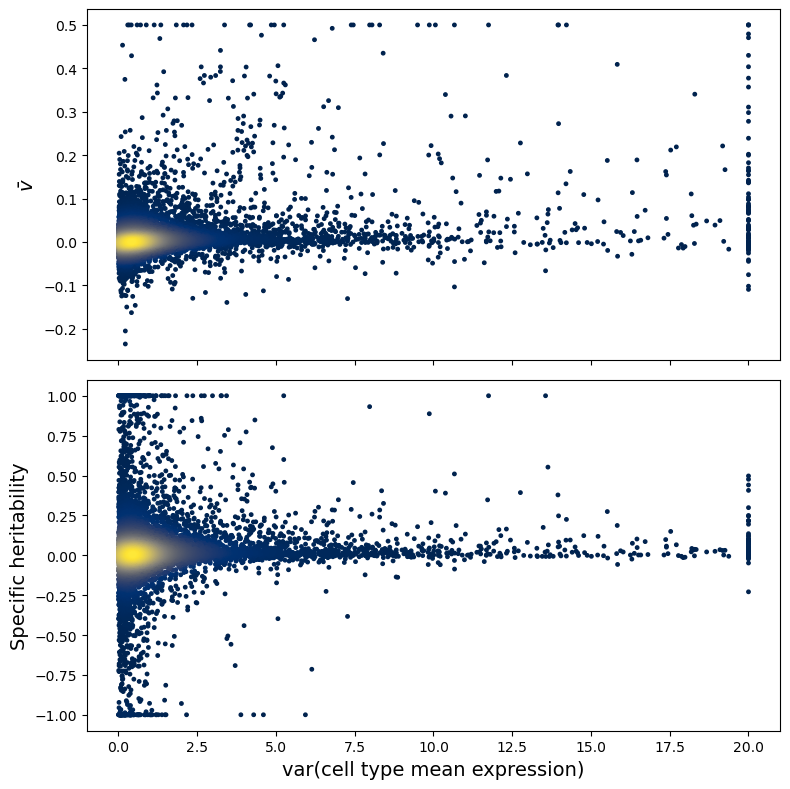

In [9]:
# print(jk_data.columns)
# print(jk_data.shape)
m = 200
v_genes = jk_data.nlargest(m, 'V', keep='all')['feature'].to_list()
beta_genes = jk_data.nlargest(m, 'var_beta', keep='all')['feature'].to_list()
assert (len(v_genes) == m) and (len(beta_genes) == m)
# print(jk_data.nlargest(m, 'var_beta', keep='all')['raw_p_beta'].sort_values(ascending=False))

common_genes = list(set(v_genes) & set(beta_genes))
p = stats.hypergeom.sf(len(common_genes) - 1, jk_data.shape[0], len(v_genes), len(beta_genes))
print(len(common_genes), p)

# spearman correlation
print(stats.spearmanr(jk_data['specific_h2'], jk_data['var_beta']))
print(stats.spearmanr(jk_data['v_bar'], jk_data['var_beta']))

# point plot of specific h2 vs var_beta
fig, axes = plt.subplots(nrows=2, figsize=(8, 8), sharex=True)
plot.scatter(jk_data['var_beta'].clip(np.nan, 20), jk_data['v_bar'].clip(np.nan, .5), 
            s=6, ax=axes[0], heatscatter=True)
plot.scatter(jk_data['var_beta'].clip(np.nan, 20), jk_data['specific_h2'].clip(-1, 1), 
            s=6, ax=axes[1], heatscatter=True)
axes[0].set_ylabel(r'$\bar{v}$', fontsize=14)
axes[1].set_xlabel('var(cell type mean expression)', fontsize=14)
axes[1].set_ylabel('Specific heritability', fontsize=14)
fig.tight_layout()

# Supp: various QC

In [10]:
def summary(df, filters, rng, confidence_level=.95):
    data = {'gene no':[], 
        'shared (mean)':[], 'specific (mean)': [], 'shared (median)':[], 'specific (median)': [], 'shared (ratio)': [], 'specific (ratio)': [],
        'shared_mean_ci':[], 'specific_mean_ci':[], 'shared_median_ci':[],'specific_median_ci':[],'shared_ratio_ci':[], 'specific_ratio_ci':[],
        'trans shared (mean)':[], 'trans specific (mean)': [], 'trans shared (median)':[], 'trans specific (median)': [], 'trans shared (ratio)': [], 'trans specific (ratio)': [],
        'trans shared_mean_ci':[], 'trans specific_mean_ci':[], 'trans shared_median_ci':[],'trans specific_median_ci':[],'trans shared_ratio_ci':[], 'trans specific_ratio_ci':[],
        }
        # 'specificity (mean)':[], 'specificity (median)':[], 'specificity (ratio)':[],
        # 'specificity_mean_ci':[], 'specificity_median_ci':[], 'specificity_ratio_ci':[],
        # 'trans specificity (mean)':[], 'trans specificity (median)':[], 'trans specificity (ratio)':[],
        # 'trans specificity_mean_ci':[], 'trans specificity_median_ci':[], 'trans specificity_ratio_ci':[],
    for filter in filters:
        data['gene no'].append(filter.sum())

        data['shared (mean)'].append(np.mean(df['shared_h2'][filter]))
        data['specific (mean)'].append(np.mean(df['specific_h2'][filter]))
        data['shared (median)'].append(np.median(df['shared_h2'][filter]))
        data['specific (median)'].append(np.median(df['specific_h2'][filter]))
        data['shared (ratio)' ].append(np.mean(df['hom_g2'][filter]) / np.mean(df['bio_var'][filter]))
        data['specific (ratio)'].append(np.mean(df['V_bar'][filter]) / np.mean(df['bio_var'][filter]))
        # data['specificity (mean)'].append(np.mean(df['specificity'][filter]))
        # data['specificity (median)'].append(np.median(df['specificity'][filter]))
        # data['specificity (ratio)'].append(np.mean(df['V_bar'][filter]) / np.mean((df['hom_g2'] + df['V_bar'])[filter]))

        data['trans shared (mean)'].append(np.mean(df['shared_h2_b'][filter]))
        data['trans specific (mean)'].append(np.mean(df['specific_h2_b'][filter]))
        data['trans shared (median)'].append(np.median(df['shared_h2_b'][filter]))
        data['trans specific (median)'].append(np.median(df['specific_h2_b'][filter]))
        data['trans shared (ratio)' ].append(np.mean(df['hom_g2_b'][filter]) / np.mean(df['bio_var'][filter]))
        data['trans specific (ratio)'].append(np.mean(df['V_b_bar'][filter]) / np.mean(df['bio_var'][filter]))
        # data['trans specificity (mean)'].append(np.mean(df['specificity_b'][filter]))
        # data['trans specificity (median)'].append(np.median(df['specificity_b'][filter]))
        # data['trans specificity (ratio)'].append(np.mean(df['V_b_bar'][filter]) / np.mean((df['hom_g2_b'] + df['V_b_bar'])[filter]))


        data['shared_mean_ci'].append(np.array(stats.bootstrap((df['shared_h2'][filter],), np.mean, 
                                vectorized=False, paired=False, random_state=rng, confidence_level=confidence_level
                                ).confidence_interval))
        data['specific_mean_ci'].append(np.array(stats.bootstrap((df['specific_h2'][filter],), np.mean, 
                                vectorized=False, paired=False, random_state=rng, confidence_level=confidence_level
                                ).confidence_interval))
        data['shared_median_ci'].append(np.array(stats.bootstrap((df['shared_h2'][filter],), np.median, 
                                vectorized=False, paired=False, random_state=rng, confidence_level=confidence_level
                                ).confidence_interval))
        data['specific_median_ci'].append(np.array(stats.bootstrap((df['specific_h2'][filter],), np.median, 
                                vectorized=False, paired=False, random_state=rng, confidence_level=confidence_level
                                ).confidence_interval))
        data['shared_ratio_ci'].append(np.array(stats.bootstrap((df['hom_g2'][filter], df['bio_var'][filter]), lambda x, y: np.mean(x) / np.mean(y), 
                                vectorized=False, paired=True, random_state=rng, confidence_level=confidence_level
                                ).confidence_interval))
        data['specific_ratio_ci'].append(np.array(stats.bootstrap((df['V_bar'][filter], df['bio_var'][filter]), lambda x, y: np.mean(x) / np.mean(y),
                                vectorized=False, paired=True, random_state=rng, confidence_level=confidence_level
                                ).confidence_interval))
        # data['specificity_mean_ci'].append(np.array(stats.bootstrap((df['specificity'][filter], ), np.mean, 
        #                         vectorized=False, paired=False, random_state=rng
        #                         ).confidence_interval))
        # data['specificity_median_ci'].append(np.array(stats.bootstrap((df['specificity'][filter], ), np.median,
        #                         vectorized=False, paired=False, random_state=rng
        #                         ).confidence_interval))
        # data['specificity_ratio_ci'].append(np.array(stats.bootstrap((df['V_bar'][filter], (df['hom_g2'] + df['V_bar'])[filter]), lambda x, y: np.mean(x) / np.mean(y), 
        #                         vectorized=False, paired=True, random_state=rng
        #                         ).confidence_interval))


        data['trans shared_mean_ci'].append(np.array(stats.bootstrap((df['shared_h2_b'][filter],), np.mean, 
                                vectorized=False, paired=False, random_state=rng, confidence_level=confidence_level
                                ).confidence_interval))
        data['trans specific_mean_ci'].append(np.array(stats.bootstrap((df['specific_h2_b'][filter],), np.mean, 
                                vectorized=False, paired=False, random_state=rng, confidence_level=confidence_level
                                ).confidence_interval))
        data['trans shared_median_ci'].append(np.array(stats.bootstrap((df['shared_h2_b'][filter],), np.median, 
                                vectorized=False, paired=False, random_state=rng, confidence_level=confidence_level
                                ).confidence_interval))
        data['trans specific_median_ci'].append(np.array(stats.bootstrap((df['specific_h2_b'][filter],), np.median, 
                                vectorized=False, paired=False, random_state=rng, confidence_level=confidence_level
                                ).confidence_interval))
        data['trans shared_ratio_ci'].append(np.array(stats.bootstrap((df['hom_g2_b'][filter], df['bio_var'][filter]), lambda x, y: np.mean(x) / np.mean(y), 
                                vectorized=False, paired=True, random_state=rng, confidence_level=confidence_level
                                ).confidence_interval))
        data['trans specific_ratio_ci'].append(np.array(stats.bootstrap((df['V_b_bar'][filter], df['bio_var'][filter]), lambda x, y: np.mean(x) / np.mean(y),
                                vectorized=False, paired=True, random_state=rng, confidence_level=confidence_level
                                ).confidence_interval))
        # data['trans specificity_mean_ci'].append(np.array(stats.bootstrap((df['specificity_b'][filter], ), np.mean, 
        #                         vectorized=False, paired=False, random_state=rng
        #                         ).confidence_interval))
        # data['trans specificity_median_ci'].append(np.array(stats.bootstrap((df['specificity_b'][filter], ), np.median,
        #                         vectorized=False, paired=False, random_state=rng
        #                         ).confidence_interval))
        # data['trans specificity_ratio_ci'].append(np.array(stats.bootstrap((df['V_b_bar'][filter], (df['hom_g2_b'] + df['V_b_bar'])[filter]), lambda x, y: np.mean(x) / np.mean(y), 
        #                         vectorized=False, paired=True, random_state=rng
        #                         ).confidence_interval))

    return pd.DataFrame(data)

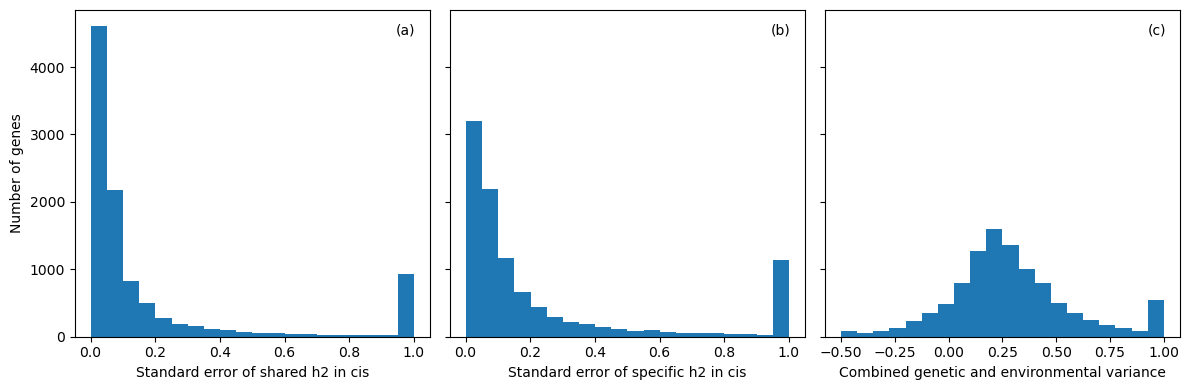

In [11]:
# supp fig: distribution of std(h2) and bio var
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)

ax = axes[0]
ax.hist(np.clip(trans_df['std_shared_h2'], a_min=None, a_max=1), bins=20)
ax.set_xlabel('Standard error of shared h2 in cis')
ax.set_ylabel('Number of genes')
ax.text(0.96, 0.96, '(a)', ha='right', va='top', transform=ax.transAxes)

ax = axes[1]
ax.hist(np.clip(trans_df['std_specific_h2'], a_min=None, a_max=1), bins=20)
ax.set_xlabel('Standard error of specific h2 in cis')
ax.text(0.96, 0.96, '(b)', ha='right', va='top', transform=ax.transAxes)

ax = axes[2]
ax.hist(np.clip(trans_df['bio_var'], a_min=-.5, a_max=1), bins=20)
ax.set_xlabel('Combined genetic and environmental variance')
ax.text(0.96, 0.96, '(c)', ha='right', va='top', transform=ax.transAxes)

fig.tight_layout()

In [12]:
# HE
rng = np.random.default_rng(42)

colors = sns.color_palette()
palette = {'shared (mean)': colors[0], 'specific (mean)': colors[0], 'shared (median)': colors[1],'specific (median)': colors[1],'shared (ratio)': colors[2],'specific (ratio)': colors[2]}
dashes = {'shared (mean)': '', 'specific (mean)': (2, 2), 'shared (median)': '', 'specific (median)': (2, 2), 'shared (ratio)': '', 'specific (ratio)': (2, 2)}

# filter on var(shared and specific cis h2)
cuts = [0.1, .5, 1, 10]
filters = []
for cut in cuts:
    filter = (trans_df['std_specific_h2'] < cut) & (trans_df['std_shared_h2'] < cut)
    filters.append(filter)

trans_se_filterd_df = summary(trans_df, filters, rng)
trans_se_filterd_df['cut'] = cuts

# filter on bio var
cuts = [0.01, 0.1, 0.2, 0.3]
filters = []
for cut in cuts:
    filter = trans_df['bio_var'] > cut
    # filter = filter & specificity_filter
    filters.append(filter)

trans_bio_filterd_df = summary(trans_df, filters, rng)
trans_bio_filterd_df['cut'] = cuts


print(trans_se_filterd_df[['cut', 'gene no']])
print(trans_bio_filterd_df[['cut', 'gene no']])

    cut  gene no
0   0.1     4930
1   0.5     8427
2   1.0     9039
3  10.0     9814
    cut  gene no
0  0.01     8992
1  0.10     8090
2  0.20     6296
3  0.30     4298


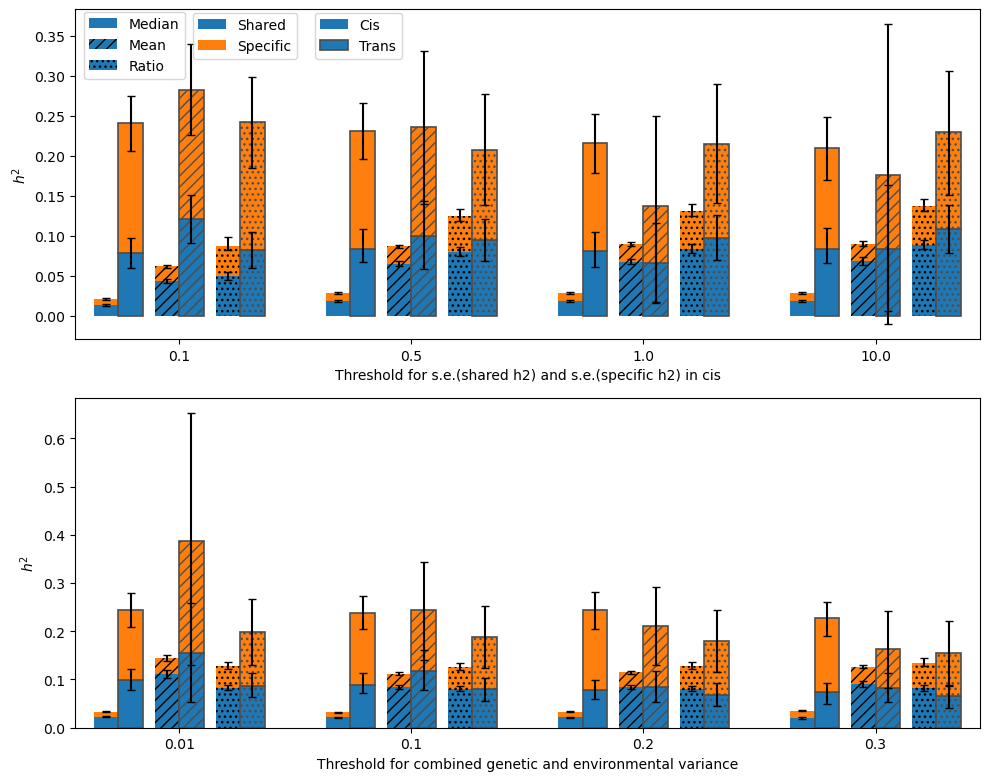

In [13]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 8))
colors = sns.color_palette()


# se(shared and specific h2)
ax = axes[0]
width = 0.105
multiplier = -2.5
x = np.arange(trans_se_filterd_df['cut'].nunique())
for measure in ['median', 'mean', 'ratio']:
    hatch = None
    if measure == 'mean':
        hatch = '///'
    elif measure == 'ratio':
        hatch = '...'
    for region in ['cis', 'trans']:
        if region == 'cis':
            offset = width * (multiplier - .5)
            # shared
            bottom = np.zeros(trans_se_filterd_df['cut'].nunique())
            values = trans_se_filterd_df[f'shared ({measure})']
            yerr=np.abs(np.vstack((trans_se_filterd_df[f'shared_{measure}_ci'].tolist())).T - trans_se_filterd_df[f'shared ({measure})'].to_numpy()[np.newaxis, :])
            ax.bar(x + offset, values, width, yerr=yerr, capsize=3, color=colors[0], hatch=hatch)
            # speccific
            bottom = values
            values = trans_se_filterd_df[f'specific ({measure})']
            yerr=np.abs(np.vstack((trans_se_filterd_df[f'specific_{measure}_ci'].tolist())).T - trans_se_filterd_df[f'specific ({measure})'].to_numpy()[np.newaxis, :])
            ax.bar(x + offset, values, width, bottom=bottom, yerr=yerr, capsize=3, color=colors[1], hatch=hatch)
        else:
            offset = width * (multiplier + .5)
            # shared
            bottom = np.zeros(trans_se_filterd_df['cut'].nunique())
            values = trans_se_filterd_df[f'trans shared ({measure})']
            yerr=np.abs(np.vstack((trans_se_filterd_df[f'trans shared_{measure}_ci'].tolist())).T - trans_se_filterd_df[f'trans shared ({measure})'].to_numpy()[np.newaxis, :])
            ax.bar(x + offset, values, width, yerr=yerr, capsize=3, color=colors[0], edgecolor='0.3', linewidth=1.2, hatch=hatch)
            # specific
            bottom = values
            values = trans_se_filterd_df[f'trans specific ({measure})']
            yerr=np.abs(np.vstack((trans_se_filterd_df[f'trans specific_{measure}_ci'].tolist())).T - trans_se_filterd_df[f'trans specific ({measure})'].to_numpy()[np.newaxis, :])
            ax.bar(x + offset, values, width, bottom=bottom, yerr=yerr, capsize=3, color=colors[1], edgecolor='0.3', linewidth=1.2, hatch=hatch)
        
    multiplier += 2.5

# make legend
bar1 = ax.bar(0, 0, 0, color=colors[0], label='Cis')
bar2 = ax.bar(0, 0, 0, color=colors[0], edgecolor='0.3', linewidth=1.2, label='Trans')
legend1 = ax.legend(handles=[bar1, bar2], loc=[0.265, 0.85])

bar3 = ax.bar(0, 0, 0, color=colors[0], label='Shared')
bar4 = ax.bar(0, 0, 0, color=colors[1], label='Specific')
legend2 = ax.legend(handles=[bar3, bar4], loc=[0.13, 0.85])

bar5 = ax.bar(0, 0, 0, color=colors[0], label='Median')
bar6 = ax.bar(0, 0, 0, color=colors[0], hatch='///', label='Mean')
bar7 = ax.bar(0, 0, 0, color=colors[0], hatch='...', label='Ratio')
legend3 = ax.legend(handles=[bar5, bar6, bar7], loc=[0.01, 0.79])

ax.add_artist(legend1)
ax.add_artist(legend2)

ax.set_xticks(x, labels=trans_se_filterd_df['cut'])
ax.set_xlim((-.45, 3.45))
ax.set_ylabel('$h^2$')
ax.set_xlabel('Threshold for s.e.(shared h2) and s.e.(specific h2) in cis')

# total var
ax = axes[1]
width = 0.105
multiplier = -2.5
x = np.arange(trans_bio_filterd_df['cut'].nunique())
for measure in ['median', 'mean', 'ratio']:
    hatch = None
    if measure == 'mean':
        hatch = '///'
    elif measure == 'ratio':
        hatch = '...'
    for region in ['cis', 'trans']:
        if region == 'cis':
            offset = width * (multiplier - .5)
            # shared
            bottom = np.zeros(trans_bio_filterd_df['cut'].nunique())
            values = trans_bio_filterd_df[f'shared ({measure})']
            yerr=np.abs(np.vstack((trans_bio_filterd_df[f'shared_{measure}_ci'].tolist())).T - trans_bio_filterd_df[f'shared ({measure})'].to_numpy()[np.newaxis, :])
            ax.bar(x + offset, values, width, yerr=yerr, capsize=3, color=colors[0], hatch=hatch)
            # speccific
            bottom = values
            values = trans_bio_filterd_df[f'specific ({measure})']
            yerr=np.abs(np.vstack((trans_bio_filterd_df[f'specific_{measure}_ci'].tolist())).T - trans_bio_filterd_df[f'specific ({measure})'].to_numpy()[np.newaxis, :])
            ax.bar(x + offset, values, width, bottom=bottom, yerr=yerr, capsize=3, color=colors[1], hatch=hatch)
        else:
            offset = width * (multiplier + .5)
            # shared
            bottom = np.zeros(trans_bio_filterd_df['cut'].nunique())
            values = trans_bio_filterd_df[f'trans shared ({measure})']
            yerr=np.abs(np.vstack((trans_bio_filterd_df[f'trans shared_{measure}_ci'].tolist())).T - trans_bio_filterd_df[f'trans shared ({measure})'].to_numpy()[np.newaxis, :])
            ax.bar(x + offset, values, width, yerr=yerr, capsize=3, color=colors[0], edgecolor='0.3', linewidth=1.2, hatch=hatch)
            # specific
            bottom = values
            values = trans_bio_filterd_df[f'trans specific ({measure})']
            yerr=np.abs(np.vstack((trans_bio_filterd_df[f'trans specific_{measure}_ci'].tolist())).T - trans_bio_filterd_df[f'trans specific ({measure})'].to_numpy()[np.newaxis, :])
            ax.bar(x + offset, values, width, bottom=bottom, yerr=yerr, capsize=3, color=colors[1], edgecolor='0.3', linewidth=1.2, hatch=hatch)
    multiplier += 2.5

ax.set_xticks(x, labels=trans_bio_filterd_df['cut'])
ax.set_xlim((-.45, 3.45))
ax.set_xlabel('Threshold for combined genetic and environmental variance')
ax.set_ylabel('$h^2$')
fig.tight_layout()

9065 genes after filtering
Cis shared: 0.022643939075989168; Cis specific median: 0.010226352865908495;
Cis specific (%): 0.3111123224577636
Trans shared median: 0.10136985303533792; Trans specific median: 0.14850067668957345;
Tans specific (%): 0.5943104889282522
Trans (%): 0.8837440884972985
[[0.0012545  0.00135241]
 [0.0233374  0.0205564 ]]
[0.02264394 0.10136985] [0.01022635 0.14850068]
9065 genes after filtering
Cis shared: 0.14869828987012348; Cis specific median: 0.06038141896072777;
Cis specific (%): 0.28879616916616846
Trans shared median: 0.27549408164350697; Trans specific median: 0.3505556605883576;
Tans specific (%): 0.559948574275629
Trans (%): 0.7496439521264711
[[0.02127725 0.04354584]
 [0.16629031 0.17215244]]
[0.14869829 0.27549408] [0.06038142 0.35055566]
9065 genes after filtering
Cis shared: 0.08312438318246487; Cis specific median: 0.04477737207400226;
Cis specific (%): 0.3500919278567772
Trans shared median: 0.08907201995783243; Trans specific median: 0.116945169

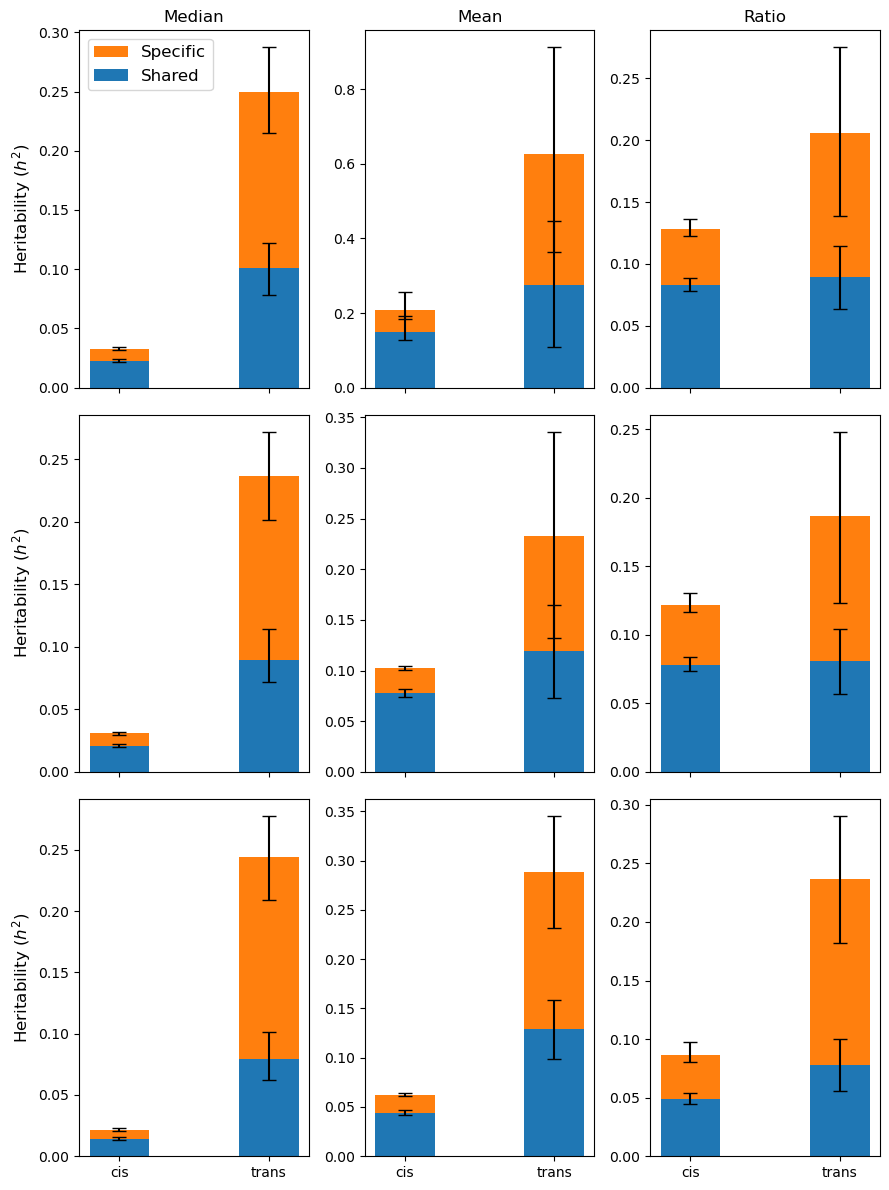

In [14]:
# supp fig
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 12), sharex=True)

ax = axes[0, 0]
plot.ctp_h2_plot(trans, ax, colors, h2='median', width=.4)
ax.legend(loc='upper left', reverse=True, fontsize=12)
ax.set_ylabel('Heritability ($h^2$)', fontsize=12)
ax.set_title('Median')

ax = axes[0, 1]
plot.ctp_h2_plot(trans, ax, colors, h2='mean_clip', width=.4)  # truncated h2 to (-100, 100)
ax.set_title('Mean')

ax = axes[0, 2]
plot.ctp_h2_plot(trans, ax, colors, h2='ratio', width=.4)
ax.set_title('Ratio')


# filter on precision of shared and specific h2
std_shared_h2 = np.sqrt(trans['p']['free']['var_shared_h2'])
std_specific_h2 = np.sqrt(trans['p']['free']['var_specific_h2'])
h2_filter = (std_shared_h2 < 1) & (std_specific_h2 < 1)
print(h2_filter.sum(), len(h2_filter))

ax = axes[1, 0]
plot.ctp_h2_plot(trans, ax, colors, h2='median', width=.4, filter=h2_filter)
ax.set_ylabel('Heritability ($h^2$)', fontsize=12)

ax = axes[1, 1]
plot.ctp_h2_plot(trans, ax, colors, h2='mean', width=.4, filter=h2_filter)

ax = axes[1, 2]
plot.ctp_h2_plot(trans, ax, colors, h2='ratio', width=.4, filter=h2_filter)


h2_filter = (std_shared_h2 < .1) & (std_specific_h2 < .1)
print(h2_filter.sum(), len(h2_filter))

ax = axes[2, 0]
plot.ctp_h2_plot(trans, ax, colors, h2='median', width=.4, filter=h2_filter)
ax.set_ylabel('Heritability ($h^2$)', fontsize=12)

ax = axes[2, 1]
plot.ctp_h2_plot(trans, ax, colors, h2='mean', width=.4, filter=h2_filter)

ax = axes[2, 2]
plot.ctp_h2_plot(trans, ax, colors, h2='ratio', width=.4, filter=h2_filter)


# ax.set_xlabel('regulatory region', fontsize=12)

fig.tight_layout()

In [15]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex='row', squeeze=False)
# # fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex='col', sharey='row', squeeze=False)
# colors = sns.color_palette()

# # filter on var(shared and specific cis h2)
# ax = axes[0, 0]
# ax.errorbar(data['cut'], data['shared (median)'], yerr=np.abs(np.vstack(data['shared_median_ci'].tolist()).T - data['shared (median)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[0], label='shared (median)')
# ax.errorbar(data['cut'], data['specific (median)'], yerr=np.abs(np.vstack(data['specific_median_ci'].tolist()).T - data['specific (median)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[0], linestyle='--', label='specific (median)')
# ax.errorbar(data['cut'], data['shared (mean)'], yerr=np.abs(np.vstack(data['shared_mean_ci'].tolist()).T - data['shared (mean)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[1], label='shared (mean)')
# ax.errorbar(data['cut'], data['specific (mean)'], yerr=np.abs(np.vstack(data['specific_mean_ci'].tolist()).T - data['specific (mean)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[1], linestyle='--', label='specific (mean)')
# ax.errorbar(data['cut'], data['shared (ratio)'], yerr=np.abs(np.vstack(data['shared_ratio_ci'].tolist()).T - data['shared (ratio)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[2], label='shared (ratio)')
# ax.errorbar(data['cut'], data['specific (ratio)'], yerr=np.abs(np.vstack(data['specific_ratio_ci'].tolist()).T - data['specific (ratio)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[2], linestyle='--', label='specific (ratio)')
# ax.set_xlabel('Threshold for s.e.(shared h2) and s.e.(specific h2) in cis')
# ax.set_ylabel('Cis h2')
# # ax.text(0.02, 1.02, 'number of genes:' + '; '.join(data['gene no'].astype(str).tolist()), ha='left', va='bottom', transform=ax.transAxes)
# ax.axhline(y=0, color='0.7')


# ax = axes[0, 1]
# ax.errorbar(data['cut'], data['trans shared (median)'], yerr=np.abs(np.vstack(data['trans shared_median_ci'].tolist()).T - data['trans shared (median)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[0], label='trans shared (median)')
# ax.errorbar(data['cut'], data['trans specific (median)'], yerr=np.abs(np.vstack(data['trans specific_median_ci'].tolist()).T - data['trans specific (median)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[0], linestyle='--', label='trans specific (median)')
# ax.errorbar(data['cut'], data['trans shared (mean)'], yerr=np.abs(np.vstack(data['trans shared_mean_ci'].tolist()).T - data['trans shared (mean)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[1], label='trans shared (mean)')
# ax.errorbar(data['cut'], data['trans specific (mean)'], yerr=np.abs(np.vstack(data['trans specific_mean_ci'].tolist()).T - data['trans specific (mean)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[1], linestyle='--', label='trans specific (mean)')
# ax.errorbar(data['cut'], data['trans shared (ratio)'], yerr=np.abs(np.vstack(data['trans shared_ratio_ci'].tolist()).T - data['trans shared (ratio)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[2], label='trans shared (ratio)')
# ax.errorbar(data['cut'], data['trans specific (ratio)'], yerr=np.abs(np.vstack(data['trans specific_ratio_ci'].tolist()).T - data['trans specific (ratio)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[2], linestyle='--', label='trans specific (ratio)')
# ax.set_xlabel('Threshold for s.e.(shared h2) and s.e.(specific h2) in cis')
# ax.set_ylabel('Trans h2')
# ax.axhline(y=0, color='0.7')


# # filter on bio var
# ax = axes[1, 0]
# ax.errorbar(data2['cut'], data2['shared (median)'], yerr=np.abs(np.vstack(data2['shared_median_ci'].tolist()).T - data2['shared (median)'].to_numpy()[np.newaxis, :]), marker='o', color=colors[0])
# ax.errorbar(data2['cut'], data2['specific (median)'], yerr=np.abs(np.vstack(data2['specific_median_ci'].tolist()).T - data2['specific (median)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[0], linestyle='--')
# ax.errorbar(data2['cut'], data2['shared (mean)'], yerr=np.abs(np.vstack(data2['shared_mean_ci'].tolist()).T - data2['shared (mean)'].to_numpy()[np.newaxis, :]), marker='o', color=colors[1])
# ax.errorbar(data2['cut'], data2['specific (mean)'], yerr=np.abs(np.vstack(data2['specific_mean_ci'].tolist()).T - data2['specific (mean)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[1], linestyle='--')
# ax.errorbar(data2['cut'], data2['shared (ratio)'], yerr=np.abs(np.vstack(data2['shared_ratio_ci'].tolist()).T - data2['shared (ratio)'].to_numpy()[np.newaxis, :]), marker='o', color=colors[2])
# ax.errorbar(data2['cut'], data2['specific (ratio)'], yerr=np.abs(np.vstack(data2['specific_ratio_ci'].tolist()).T - data2['specific (ratio)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[2], linestyle='--')
# ax.set_xlabel('Threshold for combined genetic and environmental variance')
# # ax.text(0.02, 1.02, 'number of genes:' + '; '.join(data2['gene no'].astype(str).tolist()), ha='left', va='bottom', transform=ax.transAxes)
# ax.set_ylabel('Cis h2')
# ax.axhline(y=0, color='0.7')

# ax = axes[1, 1]
# ax.errorbar(data2['cut'], data2['trans shared (median)'], yerr=np.abs(np.vstack(data2['trans shared_median_ci'].tolist()).T - data2['trans shared (median)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[0], label='Shared (median)')
# ax.errorbar(data2['cut'], data2['trans specific (median)'], yerr=np.abs(np.vstack(data2['trans specific_median_ci'].tolist()).T - data2['trans specific (median)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[0], linestyle='--', label='Specific (median)')
# ax.errorbar(data2['cut'], data2['trans shared (mean)'], yerr=np.abs(np.vstack(data2['trans shared_mean_ci'].tolist()).T - data2['trans shared (mean)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[1], label='Shared (mean)')
# ax.errorbar(data2['cut'], data2['trans specific (mean)'], yerr=np.abs(np.vstack(data2['trans specific_mean_ci'].tolist()).T - data2['trans specific (mean)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[1], linestyle='--', label='Specific (mean)')
# ax.errorbar(data2['cut'], data2['trans shared (ratio)'], yerr=np.abs(np.vstack(data2['trans shared_ratio_ci'].tolist()).T - data2['trans shared (ratio)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[2], label='Shared (ratio)')
# ax.errorbar(data2['cut'], data2['trans specific (ratio)'], yerr=np.abs(np.vstack(data2['trans specific_ratio_ci'].tolist()).T - data2['trans specific (ratio)'].to_numpy()[np.newaxis, :]), 
#             marker='o', color=colors[2], linestyle='--', label='Specific (ratio)')
# ax.set_xlabel('Threshold for combined genetic and environmental variance')
# ax.set_ylabel('Trans h2')
# ax.axhline(y=0, color='0.7')
# ax.legend(loc='upper right')

# fig.tight_layout()

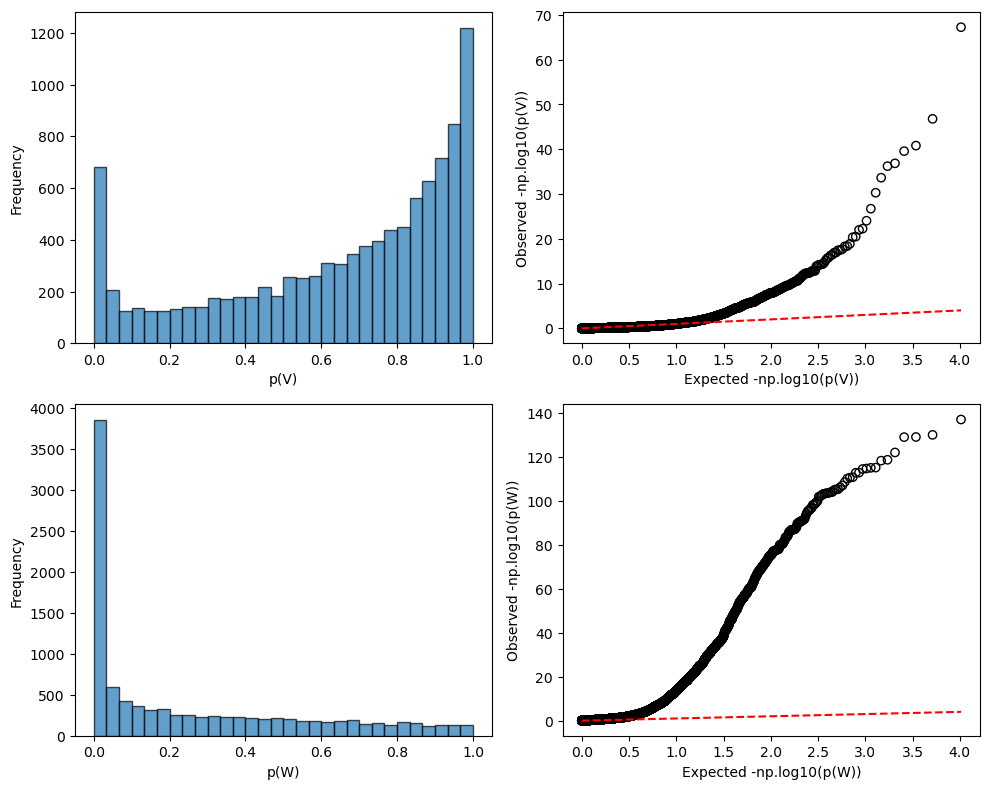

In [16]:
# Supp: QQ plot and hist
p_values = jk['p']['free']['V']
W_p_values = jk['p']['free']['W']

# Sort p-values for QQ plot
sorted_p_values = np.sort(p_values)
sorted_W_p_values = np.sort(W_p_values)

# Theoretical quantiles
quantiles = np.arange(1, len(p_values)+1) / (len(p_values)+1)
W_quantiles = np.arange(1, len(W_p_values)+1) / (len(W_p_values)+1)

# QQ plot
plt.figure(figsize=(10, 8))

# Histogram
plt.subplot(2, 2, 1)
plt.hist(p_values, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('p(V)')
plt.ylabel('Frequency')
# plt.title('Histogram of P-Values')

plt.subplot(2, 2, 2)
plt.scatter(-np.log10(quantiles), -np.log10(sorted_p_values), edgecolor='k', facecolor='none')
x_max = np.max(-np.log10(quantiles))
plt.plot([0, x_max], [0, x_max], 'r--')
plt.xlabel('Expected -np.log10(p(V))')
plt.ylabel('Observed -np.log10(p(V))')
# plt.title('QQ Plot of P-Values')

plt.subplot(2, 2, 3)
plt.hist(W_p_values, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('p(W)')
plt.ylabel('Frequency')
# plt.title('Histogram of P-Values')

plt.subplot(2, 2, 4)
plt.scatter(-np.log10(W_quantiles), -np.log10(sorted_W_p_values), edgecolor='k', facecolor='none')
x_max = np.max(-np.log10(W_quantiles))
plt.plot([0, x_max], [0, x_max], 'r--')
plt.xlabel('Expected -np.log10(p(W))')
plt.ylabel('Observed -np.log10(p(W))')
# plt.title('QQ Plot of P-Values')


plt.tight_layout()
plt.show()


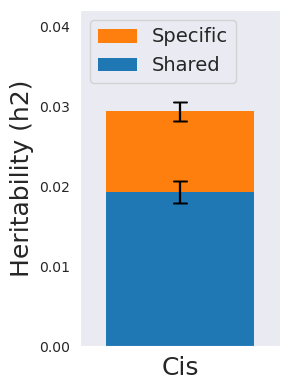

In [17]:
# fig: cis h2

# calcualte h2
rng = np.random.default_rng(42)

func = lambda x: np.median(x)
# ctp
cis_shared_h2 = func(cis['free']['shared_h2'])
cis_specific_h2 = func(cis['free']['specific_h2'])

cis_shared_h2_ci = stats.bootstrap((cis['free']['shared_h2'],), func, vectorized=False, paired=False, random_state=rng).confidence_interval
cis_specific_h2_ci = stats.bootstrap((cis['free']['specific_h2'],), func, vectorized=False, paired=False, random_state=rng).confidence_interval

# plot
colors = sns.color_palette()
sns.set_style('dark')

fig, ax = plt.subplots(figsize=(3, 4))
labels = 'Cis'

bottom = np.zeros(len(labels))
values = np.array([cis_shared_h2])
ci = np.array([cis_shared_h2_ci])
yerr = np.abs(ci - values[:, np.newaxis])
ax.bar(labels, values, yerr=yerr.T, capsize=5,
    bottom=bottom, color=colors[0], edgecolor='none', label='Shared')

bottom += values
values = np.array([cis_specific_h2])
ci = np.array([cis_specific_h2_ci])
yerr = np.abs(ci - values[:, np.newaxis])
ax.bar(labels, values, yerr=yerr.T, capsize=5,
        bottom=bottom, color=colors[1], edgecolor='none', label='Specific')
ax.set_ylim(0, .042)
ax.set_yticks([0, 0.01, 0.02, 0.03, 0.04])
ax.legend(loc='upper left', reverse=True, fontsize=14)
ax.set_ylabel('Heritability (h2)', fontsize=18)
xlims = ax.get_xlim()
ax.set_xlim((xlims[0] - 0.1, xlims[1] + 0.1))
plt.xticks(fontsize=18)
# ax.set_title('OneK1K', fontsize=20)
fig.tight_layout()


9065 genes after filtering
Cis shared: 0.022643939075989168; Cis specific median: 0.010226352865908495;
Cis specific (%): 0.3111123224577636
Trans shared median: 0.10136985303533792; Trans specific median: 0.14850067668957345;
Tans specific (%): 0.5943104889282522
Trans (%): 0.8837440884972985
[[0.00122253 0.00134953]
 [0.02384496 0.0205564 ]]
[0.02264394 0.10136985] [0.01022635 0.14850068]
trans - cis for median(specific h2) / (median(shared h2) + median(specific h2)) = 0.2831981664704886 with p = 0.0001


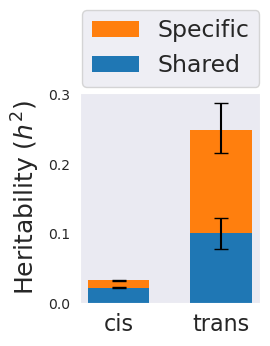

In [18]:
#fig 1: cis Transcriptome-wide + Trans transcriptome-wide
sns.set_style('dark')

fig, ax = plt.subplots(figsize=(2.8, 4))
dif, p = plot.ctp_h2_plot(trans, ax, colors, h2='median', width=.6)
ax.legend(loc='upper left', bbox_to_anchor=(-.05, 1.45), reverse=True, fontsize=17)
ax.set_ylabel('Heritability ($h^2$)', fontsize=18)
ax.set_yticks([0, 0.1, 0.2, 0.3])
ax.tick_params(axis='x', labelsize=16)
print(f'trans - cis for median(specific h2) / (median(shared h2) + median(specific h2)) = {dif} with p = {p}')
# ax.set_ylim(0, .35)

fig.tight_layout()

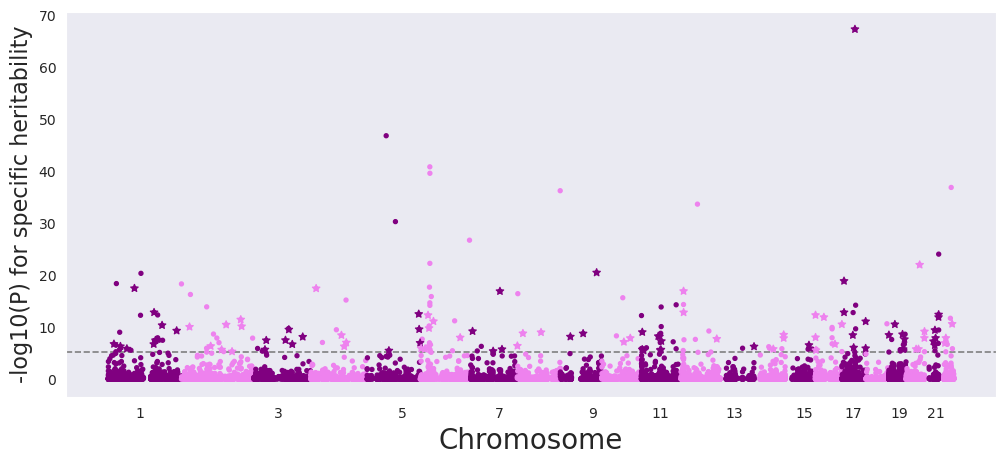

In [19]:
fig, ax = plt.subplots(figsize=(12, 5))
light_dark_green = mcolors.ListedColormap(['violet', 'purple'])
cut = -np.log10(0.05 / jk_data.shape[0])
v = 'V'
sig_V = jk_data.loc[jk_data[v] > cut, :]
sig_W = jk_data.loc[jk_data[w] > cut, :]
sig_V_only = jk_data.loc[(jk_data[v] > cut) & (jk_data[w] < cut), :]
ax.scatter(jk_data['start_cum'], jk_data[v], c=jk_data['chr'] % 2, cmap=light_dark_green, s=8, label='cell type-specific genetic effects (V)')
ax.scatter(sig_V_only['start_cum'], sig_V_only[v], c=sig_V_only['chr'] % 2, cmap=light_dark_green, marker='*', s=30)
ax.set_xticks(chr_ticks[::2])
ax.set_xticklabels(jk_data['chr'].unique()[::2])
ax.set_xlabel('Chromosome', fontsize=20)
ax.set_ylabel('-log10(P) for specific heritability', fontsize=16)
ax.axhline(cut, color='0.5', lw=1.2, ls='--', zorder=0)

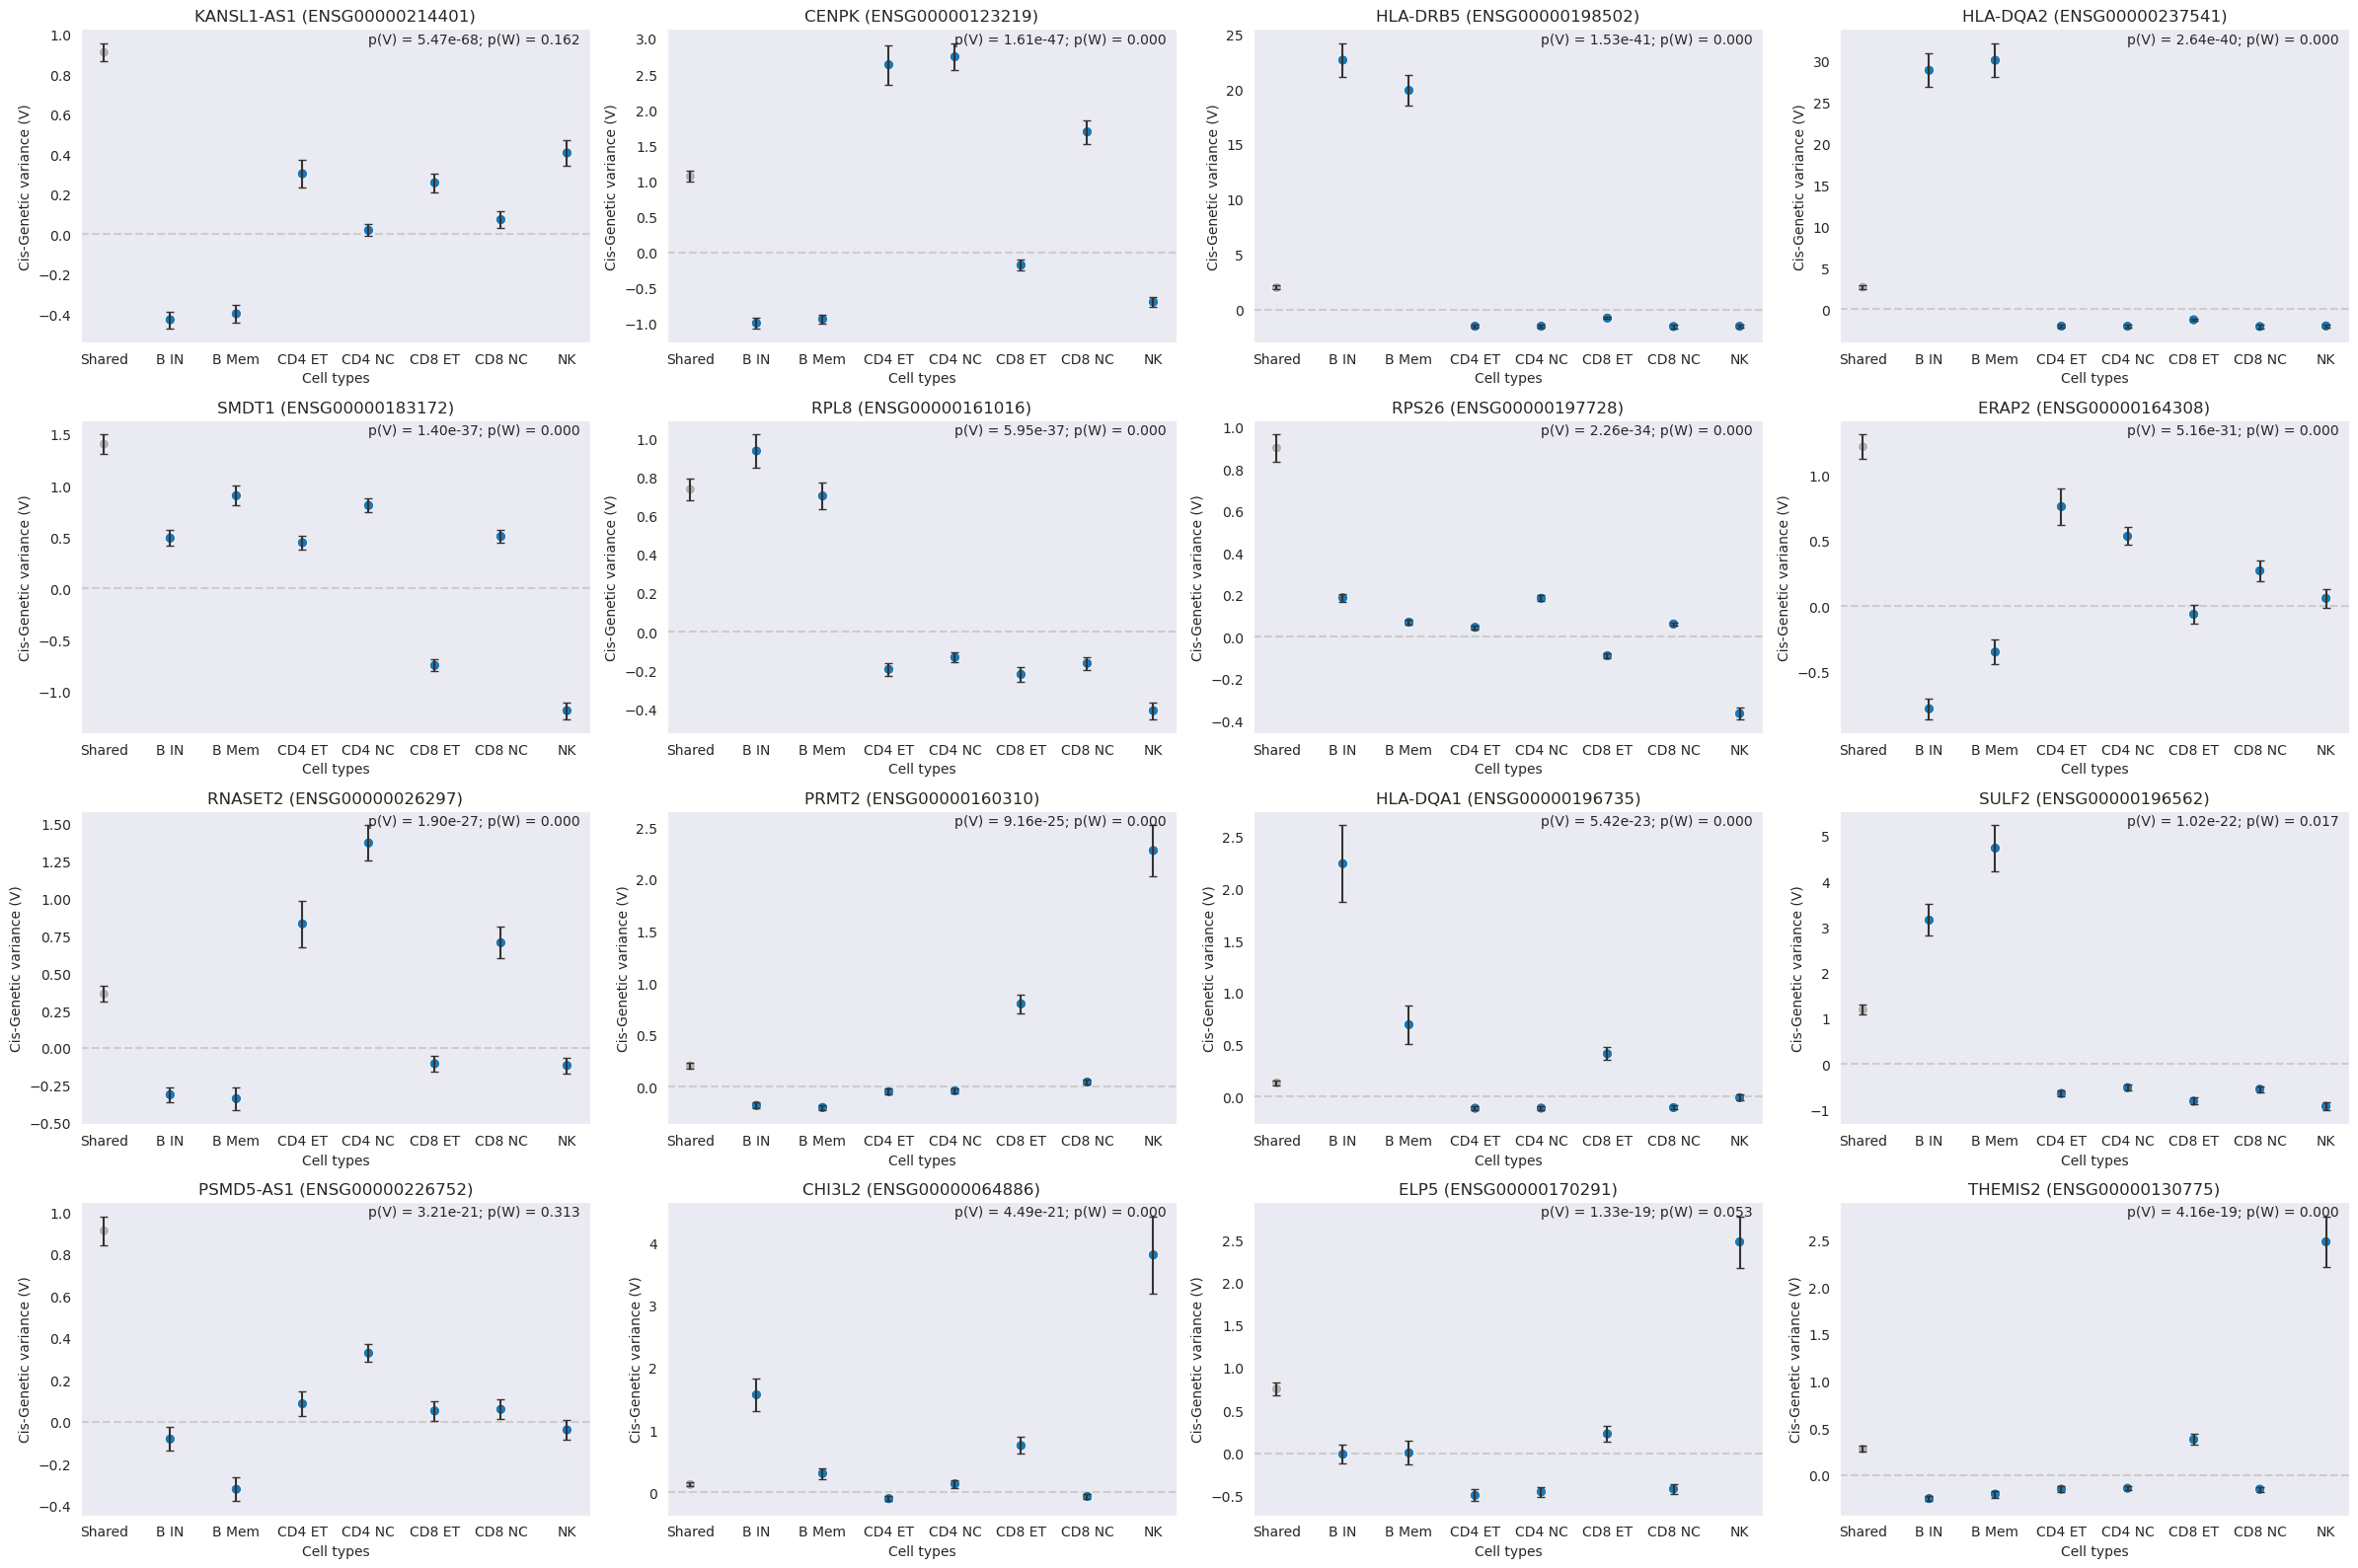

In [20]:
fig, axes = plt.subplots(4, 4, figsize=(24, 16))
for i, ax in enumerate(axes.flatten()):
    gene = sig_V.sort_values('V', ascending=False)['feature'].to_list()[i]
    # gene = sig_V_only['feature'].to_list()[i]
    genename = meta.loc[meta['feature'] == gene]
    index = np.where(jk_data['feature'] == gene)[0][0]
    # print(genename)
    assert genename.shape[0] == 1
    genename = genename['GeneSymbol'].to_list()[0]
    gene_homg2 = jk['free']['hom_g2'][index]
    gene_V = np.diag(jk['free']['V'][index])
    gene_std_hom_g2 = np.sqrt(jk['p']['free']['var_hom_g2'][index])
    gene_std_V = np.sqrt(np.diag(jk['p']['free']['var_V'][index]))
    gene_p_V = 10 ** (-1 * jk_data[v][index])
    gene_p_W = 10 ** (-1 * jk_data[w][index])
    gene_df = pd.DataFrame({'variable': ['Shared'] + cts, 'value': [gene_homg2] + gene_V.tolist(), 
                        'error': [gene_std_hom_g2] + gene_std_V.tolist()})
    # sns.scatterplot(data=gene_df, palette=['0.7'] + colors, x='variable', y='value', 
    sns.scatterplot(data=gene_df, palette=['0.7'] + [colors[0]] * len(cts), x='variable', y='value', 
                    hue='variable', ax=ax, marker='o', s=55)
    ax.axhline(0, ls='--', color='0.8', zorder=0)
    ax.text(0.98, 0.99, f'p(V) = {gene_p_V:.2e}; p(W) = {gene_p_W:.3f}', ha='right', va='top', transform=ax.transAxes)
    ax.legend().set_visible(False)
    ax.set_title(f'{genename} ({gene})')
    ax.set_xlabel('Cell types')
    ax.set_ylabel('Cis-Genetic variance (V)')
    ax.errorbar(gene_df['variable'], gene_df['value'], yerr=gene_df['error'], 
                    fmt='none', ecolor='0.2', capsize=3)

fig.tight_layout()

{'CTLA4'}
              feature GeneSymbol  chr      start         V        W     v_bar  \
1637  ENSG00000163599      CTLA4    2  204732509  10.15487  3.21597  0.183511   

      specific_h2  raw_p_beta  var_beta  start_cum  
1637     0.232808         0.0  0.733915  453932904  


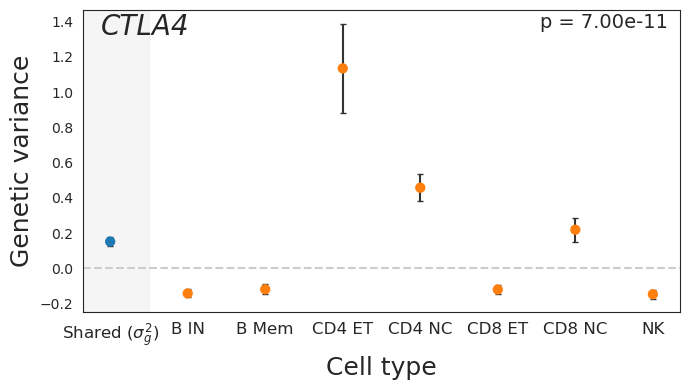

In [21]:
yazar_genes = ['SELL', 'CTLA4', 'BACH2', 'BLK']
print(set(meta.loc[meta['feature'].isin(sig_V['feature']), 'GeneSymbol'].to_list()) & set(yazar_genes))

sns.set_style('white')
fig, ax = plt.subplots(figsize=(7, 4))

genename = 'CTLA4'
gene = meta.loc[meta['GeneSymbol'] == genename, 'feature'].to_list()[0]
index = np.where(jk_data['feature'] == gene)[0][0]
gene_homg2 = jk['free']['hom_g2'][index]
gene_V = np.diag(jk['free']['V'][index])
gene_std_hom_g2 = np.sqrt(jk['p']['free']['var_hom_g2'][index])
gene_std_V = np.sqrt(np.diag(jk['p']['free']['var_V'][index]))
gene_p_V = 10 ** (-1 * jk_data[v][index])
print(jk_data.loc[jk_data['GeneSymbol'] == genename])
gene_df = pd.DataFrame({'variable': ['Shared'] + cts, 'value': [gene_homg2] + gene_V.tolist(), 
                    'error': [gene_std_hom_g2] + gene_std_V.tolist()})
sns.scatterplot(data=gene_df, palette=[colors[0]] + [colors[1]] * len(cts), x='variable', y='value', 
                hue='variable', ax=ax, marker='o', s=55, edgecolor="none", zorder=5)
ax.axhline(0, ls='--', color='0.8', zorder=1)
ax.text(0.98, 0.99, f'p = {gene_p_V:.2e}', ha='right', va='top', fontsize=14, transform=ax.transAxes)
ax.legend().set_visible(False)
# ax.set_title(f'{genename}', fontsize=18, fontstyle='italic')
ax.text(0.03, 0.99, f'{genename}', ha='left', va='top', fontsize=20, fontstyle='italic', transform=ax.transAxes)
# ax.set_xlabel('Variance component', fontsize=18)
ax.set_xlabel('Cell type', fontsize=18)
ax.set_ylabel('Genetic variance', fontsize=18)
ax.errorbar(gene_df['variable'], gene_df['value'], yerr=gene_df['error'], 
                fmt='none', ecolor='0.2', capsize=2, zorder=1)

current_labels = plt.xticks()[1]
new_labels = []
for label in current_labels:
    label = label.get_text()
    if label == 'Shared':
        new_labels.append(r'Shared ($\sigma_g^2$)')
    else:
        # label = re.sub(' ', '\ ', label)
        # new_labels.append(f"$V_{{{label}}}$")
        new_labels.append(f"{label}")
ax.set_xticks(ticks=range(len(current_labels)), labels=new_labels, fontsize=12)

xmin, xmax = ax.get_xlim()
ax.axvspan(xmin, 0.5, color='0.88', alpha=0.3, zorder=0)
ax.set_xlim((xmin, xmax))

fig.tight_layout()

In [22]:
# Supp: full gen vs env
upper_mask = np.triu(np.ones_like(full_cor, dtype=bool), k=1)

# cov
# V_cov = full_V.mean(axis=0)[upper_mask]
# W_cov = full_W.mean(axis=0)[upper_mask]

# ci_V_cov = stats.sem(full_V)[upper_mask] * 1.96  # 95% confidence interval
# ci_W_cov = stats.sem(full_W)[upper_mask] * 1.96  # 95% confidence interval
# print(ci_V)

def cal_cor(X):
    X = X.mean(axis=0)
    return (X / np.sqrt(np.outer(np.diag(X), np.diag(X))))[upper_mask]

V_cor = cal_cor(full_V)
W_cor = cal_cor(full_W)
# calculate correlation and p
r, p = stats.pearsonr(V_cor, W_cor)
print(r, p)

# ci
rng = np.random.default_rng(123)
sampled_V_cor = []
sampled_W_cor = []
for i in range(9999):
    sampled = rng.choice(full_V.shape[0], size=full_V.shape[0], replace=True)
    sampled_V = full_V[sampled, :, :]
    sampled_W = full_W[sampled, :, :]
    sampled_V_cor.append(cal_cor(sampled_V))
    sampled_W_cor.append(cal_cor(sampled_W))
ci_V_cor = np.percentile(sampled_V_cor, [2.5, 97.5], axis=0) # 95% confidence interval
ci_W_cor = np.percentile(sampled_W_cor, [2.5, 97.5], axis=0)  # 95% confidence interval


0.9523730794808328 2.991523548165629e-11


Text(0, 0.5, 'Environmental Correlation')

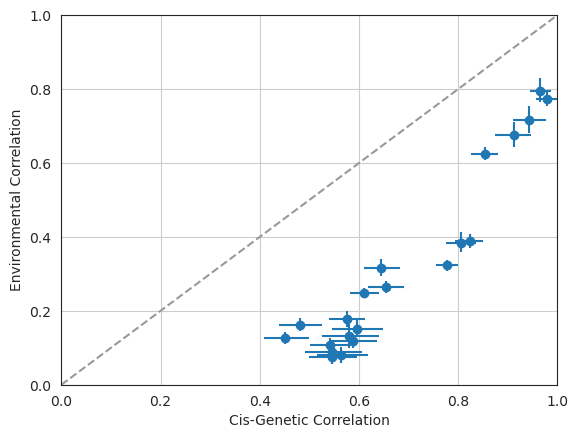

In [23]:
# Create scatter plot
fig, ax = plt.subplots()
ax.errorbar(V_cor, W_cor, xerr=np.abs(ci_V_cor - V_cor), yerr=np.abs(ci_W_cor - W_cor), fmt='o')
ax.set_xlim(0, 1)
ax.set_ylim(0, max(1, ax.get_ylim()[1]))
ax.grid(True)

# Plot y=x line
ax.plot([0, 1], [0, 1], color='0.6', linestyle='--')

# Add labels and title
ax.set_xlabel('Cis-Genetic Correlation')
ax.set_ylabel('Environmental Correlation')

# Geno PC comparison

In [24]:
joint_PC4_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~4_op_pca_n~1_batch~shared_fixed~shared/trans/he.npy'
joint_PC8_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~8_op_pca_n~1_batch~shared_fixed~shared/trans/he.npy'

joint_PC4 = np.load(joint_PC4_f, allow_pickle=True).item()
joint_PC8 = np.load(joint_PC8_f, allow_pickle=True).item()

# joint_PC4
joint_PC4_data = {'gene': joint_PC4['gene'], 
                'hom_g2': joint_PC4['free']['hom_g2'], 'V_bar': np.mean(np.diagonal(joint_PC4['free']['V'], axis1=1, axis2=2), axis=1),
                'hom_g2_b': joint_PC4['free']['hom_g2_b'], 'V_b_bar': np.mean(np.diagonal(joint_PC4['free']['V_b'], axis1=1, axis2=2), axis=1),
                'hom_e2': joint_PC4['free']['hom_e2'], 'W_bar': np.mean(np.diagonal(joint_PC4['free']['W'], axis1=1, axis2=2), axis=1),}
joint_PC4_df = pd.DataFrame(joint_PC4_data)

# joint_PC8
joint_PC8_data = {'gene': joint_PC8['gene'],
                'hom_g2': joint_PC8['free']['hom_g2'], 'V_bar': np.mean(np.diagonal(joint_PC8['free']['V'], axis1=1, axis2=2), axis=1),
                'hom_g2_b': joint_PC8['free']['hom_g2_b'], 'V_b_bar': np.mean(np.diagonal(joint_PC8['free']['V_b'], axis1=1, axis2=2), axis=1),
                'hom_e2': joint_PC8['free']['hom_e2'], 'W_bar': np.mean(np.diagonal(joint_PC8['free']['W'], axis1=1, axis2=2), axis=1)}
joint_PC8_df = pd.DataFrame(joint_PC8_data)

# merge
PC_df = trans_df.merge(joint_PC4_df, on='gene', suffixes=('', '_PC4')).merge(joint_PC8_df, on='gene', suffixes=('', '_PC8'))
# PC_df = trans_df.merge(cis_PC4_df, on='gene', suffixes=('', '_cis_PC4')).merge(cis_PC8_df, on='gene', suffixes=('', '_cis_PC8')).merge(joint_PC4_df, on='gene', suffixes=('', '_joint_PC4')).merge(joint_PC8_df, on='gene', suffixes=('', '_joint_PC8'))
print(PC_df.columns)
print(PC_df.shape)

Index(['gene', 'hom_g2', 'hom_e2', 'hom_g2_p', 'V_bar', 'V_p', 'W_bar',
       'shared_h2', 'specific_h2', 'std_shared_h2', 'std_specific_h2',
       'hom_g2_b', 'V_b_bar', 'bio_var', 'shared_h2_b', 'specific_h2_b',
       'std_shared_h2_b', 'std_specific_h2_b', 'hom_g2_PC4', 'V_bar_PC4',
       'hom_g2_b_PC4', 'V_b_bar_PC4', 'hom_e2_PC4', 'W_bar_PC4', 'hom_g2_PC8',
       'V_bar_PC8', 'hom_g2_b_PC8', 'V_b_bar_PC8', 'hom_e2_PC8', 'W_bar_PC8'],
      dtype='object')
(10288, 30)


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


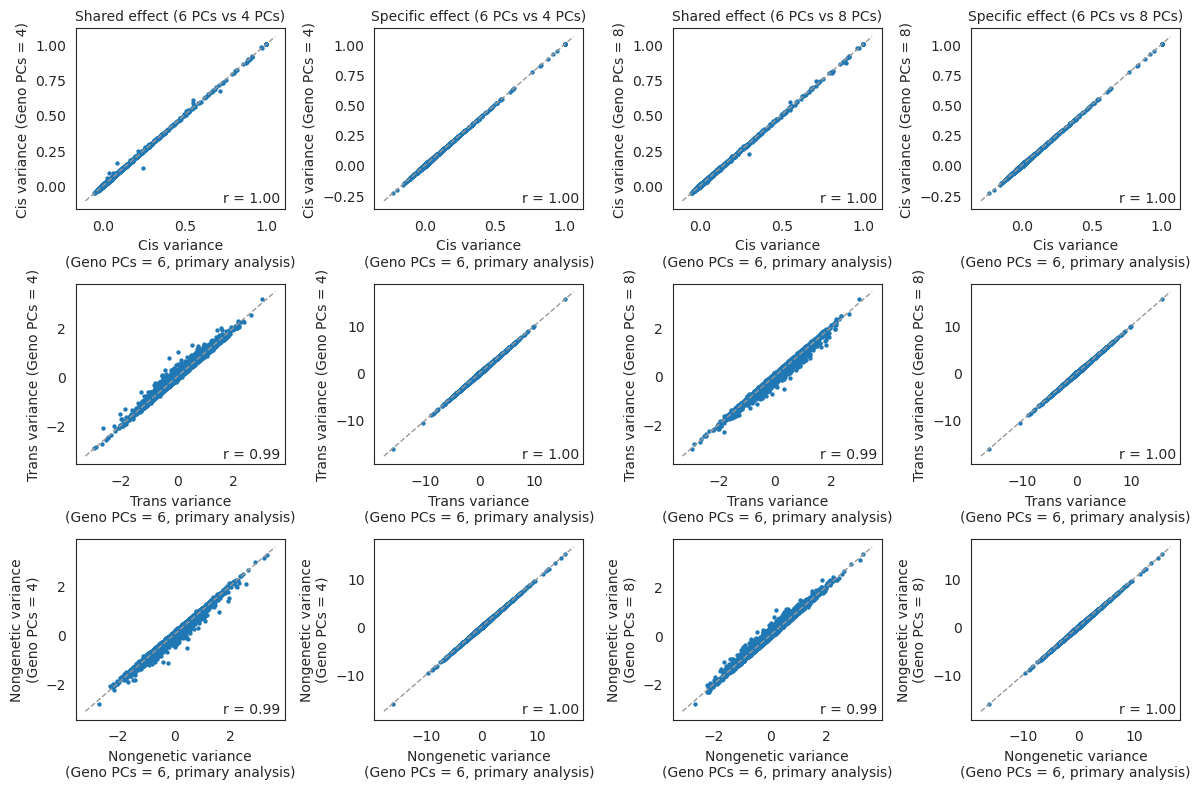

In [25]:
s = 18
fs = 10

# plot
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

axes[0, 0].scatter(PC_df['hom_g2'].clip(np.nan, 1), PC_df['hom_g2_PC4'].clip(np.nan, 1), marker='.', s=s)
r, p = stats.pearsonr(PC_df['hom_g2'], PC_df['hom_g2_PC4'])
print(p)
axes[0, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 0].transAxes)

axes[0, 1].scatter(PC_df['V_bar'].clip(np.nan, 1), PC_df['V_bar_PC4'].clip(np.nan, 1), marker='.', s=s)
r, p = stats.pearsonr(PC_df['V_bar'], PC_df['V_bar_PC4'])
print(p)
axes[0, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 1].transAxes)

ax = axes[0, 2]
ax.scatter(PC_df['hom_g2'].clip(np.nan, 1), PC_df['hom_g2_PC8'].clip(np.nan, 1), marker='.', s=s)
r, p = stats.pearsonr(PC_df['hom_g2'], PC_df['hom_g2_PC8'])
print(p)
ax.text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=ax.transAxes)

ax = axes[0, 3]
ax.scatter(PC_df['V_bar'].clip(np.nan, 1), PC_df['V_bar_PC8'].clip(np.nan, 1), marker='.', s=s)
r, p = stats.pearsonr(PC_df['V_bar'], PC_df['V_bar_PC8'])
print(p)
ax.text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=ax.transAxes)

ax = axes[1, 0]
ax.scatter(PC_df['hom_g2_b'], PC_df['hom_g2_b_PC4'], marker='.', s=s)
r, p = stats.pearsonr(PC_df['hom_g2_b'], PC_df['hom_g2_b_PC4'])
print(p)
ax.text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=ax.transAxes)

ax = axes[1, 1]
ax.scatter(PC_df['V_b_bar'], PC_df['V_b_bar_PC4'], marker='.', s=s)
r, p = stats.pearsonr(PC_df['V_b_bar'], PC_df['V_b_bar_PC4'])
print(p)
ax.text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=ax.transAxes)

ax = axes[1, 2]
ax.scatter(PC_df['hom_g2_b'], PC_df['hom_g2_b_PC8'], marker='.', s=s)
r, p = stats.pearsonr(PC_df['hom_g2_b'], PC_df['hom_g2_b_PC8'])
print(p)
ax.text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=ax.transAxes)

ax = axes[1, 3]
ax.scatter(PC_df['V_b_bar'], PC_df['V_b_bar_PC8'], marker='.', s=s)
r, p = stats.pearsonr(PC_df['V_b_bar'], PC_df['V_b_bar_PC8'])
print(p)
ax.text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=ax.transAxes)

ax = axes[2, 0]
ax.scatter(PC_df['hom_e2'], PC_df['hom_e2_PC4'], marker='.', s=s)
r, p = stats.pearsonr(PC_df['hom_e2'], PC_df['hom_e2_PC4'])
print(p)
ax.text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=ax.transAxes)

ax = axes[2, 1]
ax.scatter(PC_df['W_bar'], PC_df['W_bar_PC4'], marker='.', s=s)
r, p = stats.pearsonr(PC_df['W_bar'], PC_df['W_bar_PC4'])
print(p)
ax.text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=ax.transAxes)

ax = axes[2, 2]
ax.scatter(PC_df['hom_e2'], PC_df['hom_e2_PC8'], marker='.', s=s)
r, p = stats.pearsonr(PC_df['hom_e2'], PC_df['hom_e2_PC8'])
print(p)
ax.text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=ax.transAxes)

ax = axes[2, 3]
ax.scatter(PC_df['W_bar'], PC_df['W_bar_PC8'], marker='.', s=s)
r, p = stats.pearsonr(PC_df['W_bar'], PC_df['W_bar_PC8'])
print(p)
ax.text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=ax.transAxes)


axes[0, 0].set_title('Shared effect (6 PCs vs 4 PCs)', fontsize=fs)
axes[0, 1].set_title('Specific effect (6 PCs vs 4 PCs)', fontsize=fs)
axes[0, 2].set_title('Shared effect (6 PCs vs 8 PCs)', fontsize=fs)
axes[0, 3].set_title('Specific effect (6 PCs vs 8 PCs)', fontsize=fs)

axes[0, 0].set_xlabel('Cis variance\n(Geno PCs = 6, primary analysis)')
axes[0, 0].set_ylabel('Cis variance (Geno PCs = 4)')
axes[0, 1].set_xlabel('Cis variance\n(Geno PCs = 6, primary analysis)')
axes[0, 1].set_ylabel('Cis variance (Geno PCs = 4)')

axes[0, 2].set_xlabel('Cis variance\n(Geno PCs = 6, primary analysis)')
axes[0, 2].set_ylabel('Cis variance (Geno PCs = 8)')
axes[0, 3].set_xlabel('Cis variance\n(Geno PCs = 6, primary analysis)')
axes[0, 3].set_ylabel('Cis variance (Geno PCs = 8)')

axes[1, 0].set_xlabel('Trans variance\n(Geno PCs = 6, primary analysis)')
axes[1, 0].set_ylabel('Trans variance (Geno PCs = 4)')
axes[1, 1].set_xlabel('Trans variance\n(Geno PCs = 6, primary analysis)')
axes[1, 1].set_ylabel('Trans variance (Geno PCs = 4)')

axes[1, 2].set_xlabel('Trans variance\n(Geno PCs = 6, primary analysis)')
axes[1, 2].set_ylabel('Trans variance (Geno PCs = 8)')
axes[1, 3].set_xlabel('Trans variance\n(Geno PCs = 6, primary analysis)')
axes[1, 3].set_ylabel('Trans variance (Geno PCs = 8)')

axes[2, 0].set_xlabel('Nongenetic variance\n(Geno PCs = 6, primary analysis)')
axes[2, 0].set_ylabel('Nongenetic variance\n(Geno PCs = 4)')
axes[2, 1].set_xlabel('Nongenetic variance\n(Geno PCs = 6, primary analysis)')
axes[2, 1].set_ylabel('Nongenetic variance\n(Geno PCs = 4)')

axes[2, 2].set_xlabel('Nongenetic variance\n(Geno PCs = 6, primary analysis)')
axes[2, 2].set_ylabel('Nongenetic variance\n(Geno PCs = 8)')
axes[2, 3].set_xlabel('Nongenetic variance\n(Geno PCs = 6, primary analysis)')
axes[2, 3].set_ylabel('Nongenetic variance\n(Geno PCs = 8)')

# y = x line
for ax in axes.flatten():
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    lims = [min(xlims[0], ylims[0]), max(xlims[1], ylims[1])]
    ax.plot(lims, lims, color='0.6', linestyle='--', lw=1)

fig.tight_layout()

# Shared vs specific fixed or random effects

In [26]:
specific_batch_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~specific_fixed~shared/trans/he.npy'
specific_fixed_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~specific/trans/he.npy'
specific_both_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~specific_fixed~specific/trans/he.npy'

specific_batch = np.load(specific_batch_f, allow_pickle=True).item()
specific_fixed = np.load(specific_fixed_f, allow_pickle=True).item()
specific_both = np.load(specific_both_f, allow_pickle=True).item()

# specific batch
specific_batch_data = {'gene': specific_batch['gene'], 
                'hom_g2': specific_batch['free']['hom_g2'], 'V_bar': np.mean(np.diagonal(specific_batch['free']['V'], axis1=1, axis2=2), axis=1),
                'hom_g2_b': specific_batch['free']['hom_g2_b'], 'V_b_bar': np.mean(np.diagonal(specific_batch['free']['V_b'], axis1=1, axis2=2), axis=1),
                'hom_e2': specific_batch['free']['hom_e2'], 'W_bar': np.mean(np.diagonal(specific_batch['free']['W'], axis1=1, axis2=2), axis=1),}
specific_batch_df = pd.DataFrame(specific_batch_data)

# specific fixed
specific_fixed_data = {'gene': specific_fixed['gene'],
                'hom_g2': specific_fixed['free']['hom_g2'], 'V_bar': np.mean(np.diagonal(specific_fixed['free']['V'], axis1=1, axis2=2), axis=1),
                'hom_g2_b': specific_fixed['free']['hom_g2_b'], 'V_b_bar': np.mean(np.diagonal(specific_fixed['free']['V_b'], axis1=1, axis2=2), axis=1),
                'hom_e2': specific_fixed['free']['hom_e2'], 'W_bar': np.mean(np.diagonal(specific_fixed['free']['W'], axis1=1, axis2=2), axis=1)}
specific_fixed_df = pd.DataFrame(specific_fixed_data)

# specific both
specific_both_data = {'gene': specific_both['gene'],
                'hom_g2': specific_both['free']['hom_g2'], 'V_bar': np.mean(np.diagonal(specific_both['free']['V'], axis1=1, axis2=2), axis=1),
                'hom_g2_b': specific_both['free']['hom_g2_b'], 'V_b_bar': np.mean(np.diagonal(specific_both['free']['V_b'], axis1=1, axis2=2), axis=1),
                'hom_e2': specific_both['free']['hom_e2'], 'W_bar': np.mean(np.diagonal(specific_both['free']['W'], axis1=1, axis2=2), axis=1)}
specific_both_df = pd.DataFrame(specific_both_data)

# merge
specific_df = trans_df.merge(specific_batch_df, on='gene', suffixes=('', '_specific_batch')).merge(specific_fixed_df, on='gene', suffixes=('', '_specific_fixed')).merge(specific_both_df, on='gene', suffixes=('', '_specific_both'))
print(specific_df.columns)
print(specific_df.shape)

Index(['gene', 'hom_g2', 'hom_e2', 'hom_g2_p', 'V_bar', 'V_p', 'W_bar',
       'shared_h2', 'specific_h2', 'std_shared_h2', 'std_specific_h2',
       'hom_g2_b', 'V_b_bar', 'bio_var', 'shared_h2_b', 'specific_h2_b',
       'std_shared_h2_b', 'std_specific_h2_b', 'hom_g2_specific_batch',
       'V_bar_specific_batch', 'hom_g2_b_specific_batch',
       'V_b_bar_specific_batch', 'hom_e2_specific_batch',
       'W_bar_specific_batch', 'hom_g2_specific_fixed', 'V_bar_specific_fixed',
       'hom_g2_b_specific_fixed', 'V_b_bar_specific_fixed',
       'hom_e2_specific_fixed', 'W_bar_specific_fixed', 'hom_g2_specific_both',
       'V_bar_specific_both', 'hom_g2_b_specific_both',
       'V_b_bar_specific_both', 'hom_e2_specific_both', 'W_bar_specific_both'],
      dtype='object')
(10288, 36)


In [27]:
print(stats.pearsonr(specific_df['hom_e2'], specific_df['hom_e2_specific_batch']))
print(stats.pearsonr(specific_df['hom_e2'], specific_df['hom_e2_specific_fixed']))
print(stats.pearsonr(specific_df['W_bar'], specific_df['W_bar_specific_batch']))
stats.pearsonr(specific_batch['free']['r2']['batch'].mean(axis=1), trans['free']['r2']['batch'])

PearsonRResult(statistic=np.float64(0.9618921136249624), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float64(0.9909358660259202), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float64(0.990265787587235), pvalue=np.float64(0.0))


PearsonRResult(statistic=np.float64(0.7830221030624742), pvalue=np.float64(0.0))

In [28]:
print(np.diagonal(specific_batch['free']['V_b'], axis1=1, axis2=2)[0])
print(np.diagonal(trans['free']['V_b'], axis1=1, axis2=2)[0])
print('***************')
print(np.diagonal(specific_batch['free']['W'], axis1=1, axis2=2)[0])
print(np.diagonal(trans['free']['W'], axis1=1, axis2=2)[0])
print('***************')
print(specific_batch['free']['r2']['batch'][0])
print(trans['free']['r2']['batch'][0])


[-6.18228006 -7.29555567  2.72258732  1.28568988  0.80614188  1.87150438
 -1.54822097]
[-6.17246814 -7.28952511  2.72075072  1.28933895  0.81346384  1.87587319
 -1.54614339]
***************
[ 5.06193661  6.22328665 -2.29828743 -1.31290158 -0.65451693 -1.99786046
  2.5442579 ]
[ 5.34283181  6.38928097 -2.37134561 -1.21927158 -0.44928199 -1.8823602
  2.5901363 ]
***************
[ 0.29493959  0.1743233  -0.07662017  0.09835943  0.21551583  0.12131755
  0.04823256]
0.19418907422683548


0.0
0.0
0.0
0.0
0.0
0.0


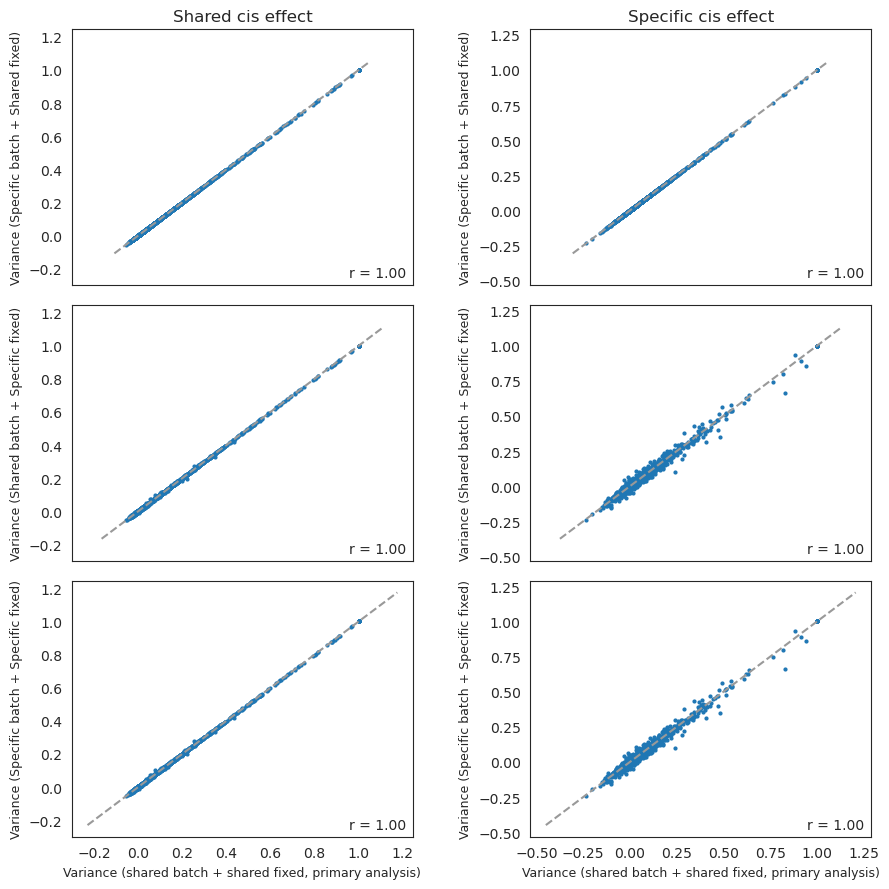

In [29]:
fs = 9
s = 16

fig, axes = plt.subplots(3, 2, figsize=(9, 9), sharex='col', sharey='col')

axes[0, 0].scatter(specific_df['hom_g2'].clip(np.nan, 1), specific_df['hom_g2_specific_batch'].clip(np.nan, 1), marker='.', s=s)
r, p = stats.pearsonr(specific_df['hom_g2'], specific_df['hom_g2_specific_batch'])
print(p)
axes[0, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 0].transAxes)

axes[0, 1].scatter(specific_df['V_bar'].clip(np.nan, 1), specific_df['V_bar_specific_batch'].clip(np.nan, 1), marker='.', s=s)
r, p = stats.pearsonr(specific_df['V_bar'], specific_df['V_bar_specific_batch'])
print(p)
axes[0, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 1].transAxes)


axes[1, 0].scatter(specific_df['hom_g2'].clip(np.nan, 1), specific_df['hom_g2_specific_fixed'].clip(np.nan, 1), marker='.', s=s)
r, p = stats.pearsonr(specific_df['hom_g2'], specific_df['hom_g2_specific_fixed'])
print(p)
axes[1, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[1, 0].transAxes)

axes[1, 1].scatter(specific_df['V_bar'].clip(np.nan, 1), specific_df['V_bar_specific_fixed'].clip(np.nan, 1), marker='.', s=s)
r, p = stats.pearsonr(specific_df['V_bar'], specific_df['V_bar_specific_fixed'])
print(p)
axes[1, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[1, 1].transAxes)


axes[2, 0].scatter(specific_df['hom_g2'].clip(np.nan, 1), specific_df['hom_g2_specific_both'].clip(np.nan, 1), marker='.', s=s)
r, p = stats.pearsonr(specific_df['hom_g2'], specific_df['hom_g2_specific_both'])
print(p)
axes[2, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[2, 0].transAxes)

axes[2, 1].scatter(specific_df['V_bar'].clip(np.nan, 1), specific_df['V_bar_specific_both'].clip(np.nan, 1), marker='.', s=s)
r, p = stats.pearsonr(specific_df['V_bar'], specific_df['V_bar_specific_both'])
print(p)
axes[2, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[2, 1].transAxes)



axes[0, 0].set_title('Shared cis effect')
axes[0, 1].set_title('Specific cis effect')

axes[0, 0].set_ylabel('Variance (Specific batch + Shared fixed)', fontsize=fs)
axes[0, 1].set_ylabel('Variance (Specific batch + Shared fixed)', fontsize=fs)

axes[1, 0].set_ylabel('Variance (Shared batch + Specific fixed)', fontsize=fs)
axes[1, 1].set_ylabel('Variance (Shared batch + Specific fixed)', fontsize=fs)

axes[2, 0].set_ylabel('Variance (Specific batch + Specific fixed)', fontsize=fs)
axes[2, 1].set_ylabel('Variance (Specific batch + Specific fixed)', fontsize=fs)

axes[2, 0].set_xlabel('Variance (shared batch + shared fixed, primary analysis)', fontsize=fs)
axes[2, 1].set_xlabel('Variance (shared batch + shared fixed, primary analysis)', fontsize=fs)

# y = x line
for ax in axes.flatten():
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    lims = [min(xlims[0], ylims[0]), max(xlims[1], ylims[1])]
    ax.plot(lims, lims, color='0.6', linestyle='--')

fig.tight_layout(w_pad=4)

0.0
0.0
0.0
0.0
0.0
0.0


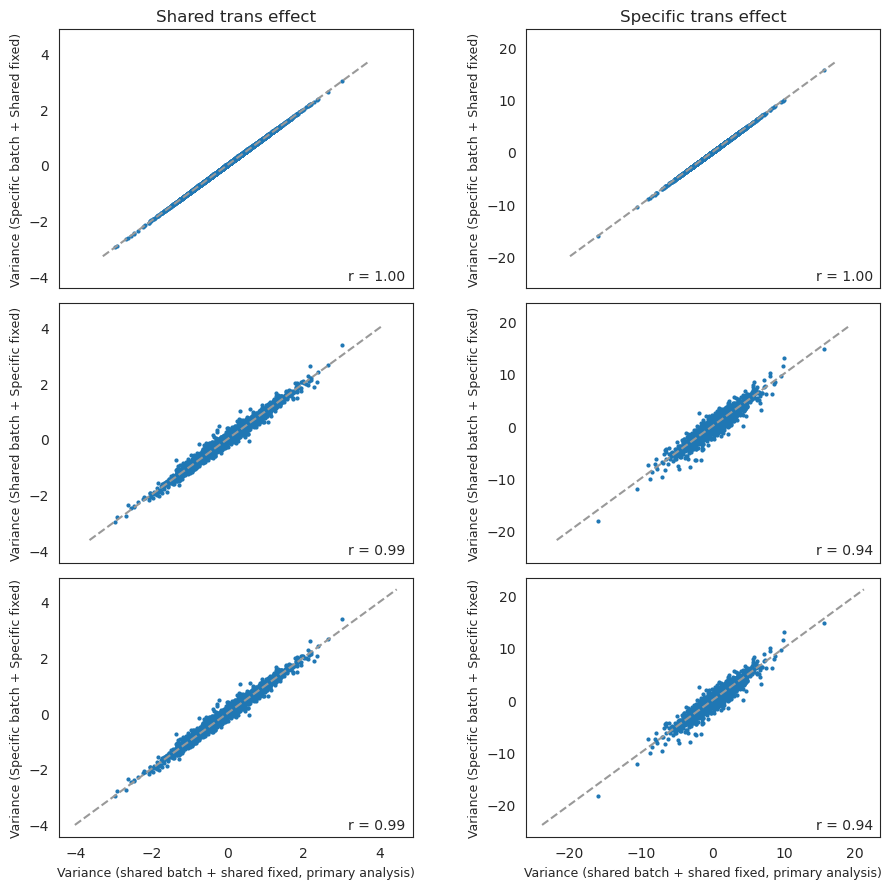

In [30]:
s = 16

fig, axes = plt.subplots(3, 2, figsize=(9, 9), sharex='col', sharey='col')

axes[0, 0].scatter(specific_df['hom_g2_b'], specific_df['hom_g2_b_specific_batch'], marker='.', s=s)
r, p = stats.pearsonr(specific_df['hom_g2_b'], specific_df['hom_g2_b_specific_batch'])
print(p)
axes[0, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 0].transAxes)

axes[0, 1].scatter(specific_df['V_b_bar'], specific_df['V_b_bar_specific_batch'], marker='.', s=s)
r, p = stats.pearsonr(specific_df['V_b_bar'], specific_df['V_b_bar_specific_batch'])
print(p)
axes[0, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 1].transAxes)

axes[1, 0].scatter(specific_df['hom_g2_b'], specific_df['hom_g2_b_specific_fixed'], marker='.', s=s)
r, p = stats.pearsonr(specific_df['hom_g2_b'], specific_df['hom_g2_b_specific_fixed'])
print(p)
axes[1, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[1, 0].transAxes)

axes[1, 1].scatter(specific_df['V_b_bar'], specific_df['V_b_bar_specific_fixed'], marker='.', s=s)
r, p = stats.pearsonr(specific_df['V_b_bar'], specific_df['V_b_bar_specific_fixed'])
print(p)
axes[1, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[1, 1].transAxes)

axes[2, 0].scatter(specific_df['hom_g2_b'], specific_df['hom_g2_b_specific_both'], marker='.', s=s)
r, p = stats.pearsonr(specific_df['hom_g2_b'], specific_df['hom_g2_b_specific_both'])
print(p)
axes[2, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[2, 0].transAxes)

axes[2, 1].scatter(specific_df['V_b_bar'], specific_df['V_b_bar_specific_both'], marker='.', s=s)
r, p = stats.pearsonr(specific_df['V_b_bar'], specific_df['V_b_bar_specific_both'])
print(p)
axes[2, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[2, 1].transAxes)

axes[0, 0].set_title('Shared trans effect')
axes[0, 1].set_title('Specific trans effect')
axes[0, 0].set_ylabel('Variance (Specific batch + Shared fixed)', fontsize=fs)
axes[0, 1].set_ylabel('Variance (Specific batch + Shared fixed)', fontsize=fs)
axes[1, 0].set_ylabel('Variance (Shared batch + Specific fixed)', fontsize=fs)
axes[1, 1].set_ylabel('Variance (Shared batch + Specific fixed)', fontsize=fs)
axes[2, 0].set_ylabel('Variance (Specific batch + Specific fixed)', fontsize=fs)
axes[2, 1].set_ylabel('Variance (Specific batch + Specific fixed)', fontsize=fs)
axes[2, 0].set_xlabel('Variance (shared batch + shared fixed, primary analysis)', fontsize=fs)
axes[2, 1].set_xlabel('Variance (shared batch + shared fixed, primary analysis)', fontsize=fs)

# y = x line
for ax in axes.flatten():
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    lims = [min(xlims[0], ylims[0]), max(xlims[1], ylims[1])]
    ax.plot(lims, lims, color='0.6', linestyle='--')

fig.tight_layout(w_pad=4)

0.0
0.0
0.0
0.0
0.0
0.0


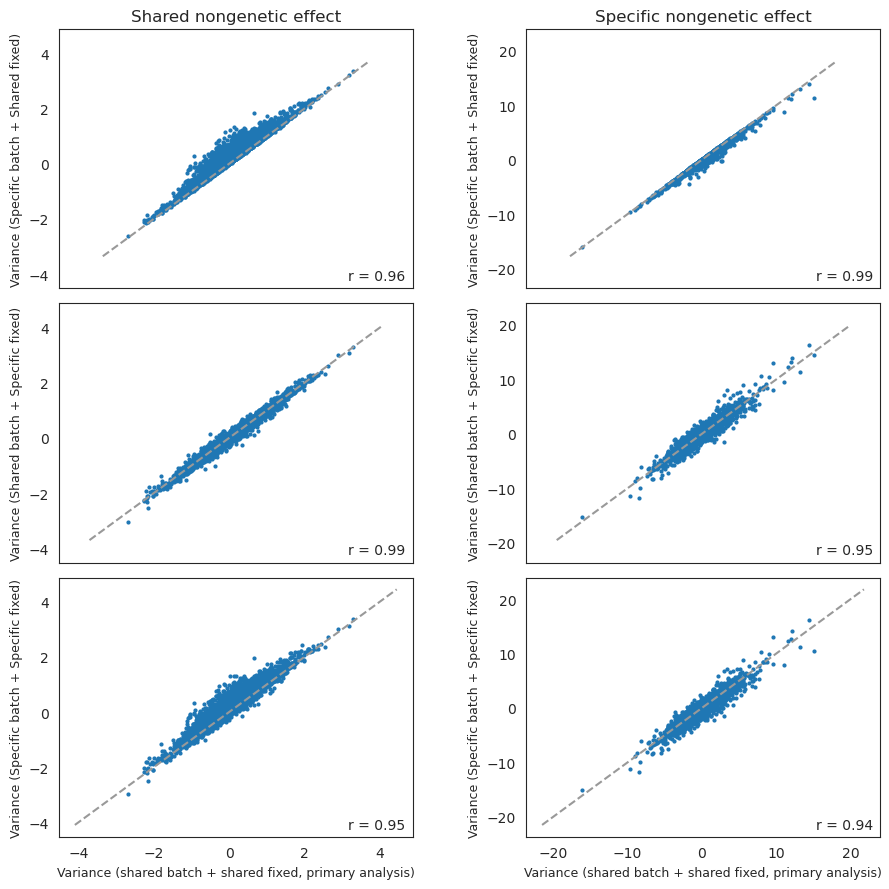

In [31]:
fs = 9
s = 16

fig, axes = plt.subplots(3, 2, figsize=(9, 9), sharex='col', sharey='col')

axes[0, 0].scatter(specific_df['hom_e2'], specific_df['hom_e2_specific_batch'], marker='.', s=s)
r, p = stats.pearsonr(specific_df['hom_e2'], specific_df['hom_e2_specific_batch'])
print(p)
axes[0, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 0].transAxes)

axes[0, 1].scatter(specific_df['W_bar'], specific_df['W_bar_specific_batch'], marker='.', s=s)
r, p = stats.pearsonr(specific_df['W_bar'], specific_df['W_bar_specific_batch'])
print(p)
axes[0, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 1].transAxes)


axes[1, 0].scatter(specific_df['hom_e2'], specific_df['hom_e2_specific_fixed'], marker='.', s=s)
r, p = stats.pearsonr(specific_df['hom_e2'], specific_df['hom_e2_specific_fixed'])
print(p)
axes[1, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[1, 0].transAxes)

axes[1, 1].scatter(specific_df['W_bar'], specific_df['W_bar_specific_fixed'], marker='.', s=s)
r, p = stats.pearsonr(specific_df['W_bar'], specific_df['W_bar_specific_fixed'])
print(p)
axes[1, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[1, 1].transAxes)


axes[2, 0].scatter(specific_df['hom_e2'], specific_df['hom_e2_specific_both'], marker='.', s=s)
r, p = stats.pearsonr(specific_df['hom_e2'], specific_df['hom_e2_specific_both'])
print(p)
axes[2, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[2, 0].transAxes)

axes[2, 1].scatter(specific_df['W_bar'], specific_df['W_bar_specific_both'], marker='.', s=s)
r, p = stats.pearsonr(specific_df['W_bar'], specific_df['W_bar_specific_both'])
print(p)
axes[2, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[2, 1].transAxes)



axes[0, 0].set_title('Shared nongenetic effect')
axes[0, 1].set_title('Specific nongenetic effect')

axes[0, 0].set_ylabel('Variance (Specific batch + Shared fixed)', fontsize=fs)
axes[0, 1].set_ylabel('Variance (Specific batch + Shared fixed)', fontsize=fs)

axes[1, 0].set_ylabel('Variance (Shared batch + Specific fixed)', fontsize=fs)
axes[1, 1].set_ylabel('Variance (Shared batch + Specific fixed)', fontsize=fs)

axes[2, 0].set_ylabel('Variance (Specific batch + Specific fixed)', fontsize=fs)
axes[2, 1].set_ylabel('Variance (Specific batch + Specific fixed)', fontsize=fs)

axes[2, 0].set_xlabel('Variance (shared batch + shared fixed, primary analysis)', fontsize=fs)
axes[2, 1].set_xlabel('Variance (shared batch + shared fixed, primary analysis)', fontsize=fs)

# y = x line
for ax in axes.flatten():
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    lims = [min(xlims[0], ylims[0]), max(xlims[1], ylims[1])]
    ax.plot(lims, lims, color='0.6', linestyle='--')

fig.tight_layout(w_pad=4)

# Cell type number

In [32]:
joint_ct4_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/trans/mainct/he.npy'
joint_ct4_P_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/mainct/P.final.gz'

joint_ct4 = np.load(joint_ct4_f, allow_pickle=True).item()
joint_ct4_P = pd.read_table(joint_ct4_P_f, index_col=0)
ct4_cts = joint_ct4_P.columns.to_numpy()
print(ct4_cts)
default_cts = P.columns.to_numpy()

# joint_ct4
joint_ct4_data = {'gene': joint_ct4['gene'], 
                'hom_g2': joint_ct4['free']['hom_g2'], 'V_bar': np.mean(np.diagonal(joint_ct4['free']['V'], axis1=1, axis2=2), axis=1),
                'hom_g2_b': joint_ct4['free']['hom_g2_b'], 'V_b_bar': np.mean(np.diagonal(joint_ct4['free']['V_b'], axis1=1, axis2=2), axis=1),
                'hom_e2': joint_ct4['free']['hom_e2'], 'W_bar': np.mean(np.diagonal(joint_ct4['free']['W'], axis1=1, axis2=2), axis=1),}
joint_ct4_df = pd.DataFrame(joint_ct4_data)


# merge
default_in_ct4 = np.isin(default_cts, ct4_cts)
trans_ct_df = pd.DataFrame({'gene': trans['gene'], 
                            'hom_g2': trans['free']['hom_g2'], 'V_bar': np.mean(np.diagonal(trans['free']['V'], axis1=1, axis2=2)[:, default_in_ct4], axis=1),
                            'hom_g2_b': trans['free']['hom_g2_b'], 'V_b_bar': np.mean(np.diagonal(trans['free']['V_b'], axis1=1, axis2=2)[:, default_in_ct4], axis=1),
                            'hom_e2': trans['free']['hom_e2'], 'W_bar': np.mean(np.diagonal(trans['free']['W'], axis1=1, axis2=2)[:, default_in_ct4], axis=1)})
merge_ct4_df = trans_ct_df.merge(joint_ct4_df, on='gene', suffixes=('', '_ct4'))

['CD4 NC' 'CD8 ET' 'CD8 NC' 'NK']


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


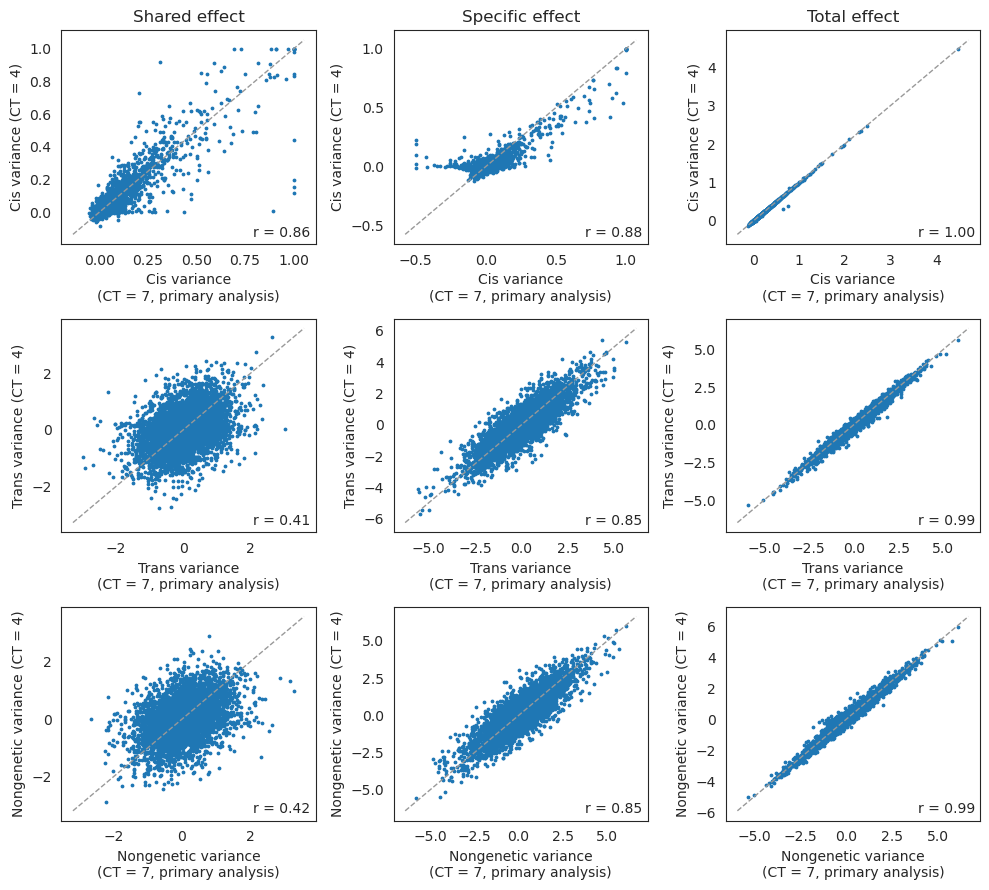

In [33]:
s = 12
lw = 1

# plot
fig, axes = plt.subplots(3, 3, figsize=(10, 9))

axes[0, 0].scatter(merge_ct4_df['hom_g2'].clip(np.nan, 1), merge_ct4_df['hom_g2_ct4'].clip(np.nan, 1.), marker='.', s=s)
# plot.scatter(merge_ct4_df['hom_g2'].clip(np.nan, 1), merge_ct4_df['hom_g2_ct4'].clip(np.nan, 1.), s=6, ax=axes[0, 0], heatscatter=True)
r, p = stats.pearsonr(merge_ct4_df['hom_g2'], merge_ct4_df['hom_g2_ct4'])
print(p)
axes[0, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 0].transAxes)

axes[0, 1].scatter(merge_ct4_df['V_bar'].clip(-.5, 1), merge_ct4_df['V_bar_ct4'].clip(-.5, 1.), marker='.', s=s)
# plot.scatter(merge_ct4_df['V_bar'].clip(-.5, 1), merge_ct4_df['V_bar_ct4'].clip(-.5, 1.), s=6, ax=axes[0, 1], heatscatter=True)
r, p = stats.pearsonr(merge_ct4_df['V_bar'], merge_ct4_df['V_bar_ct4'])
print(p)
axes[0, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 1].transAxes)

axes[0, 2].scatter(merge_ct4_df['hom_g2'] + merge_ct4_df['V_bar'], merge_ct4_df['hom_g2_ct4'] + merge_ct4_df['V_bar_ct4'], marker='.', s=s)
# plot.scatter(merge_ct4_df['hom_g2'] + merge_ct4_df['V_bar'], merge_ct4_df['hom_g2_ct4'] + merge_ct4_df['V_bar_ct4'], s=6, ax=axes[0, 2], heatscatter=True)
r, p = stats.pearsonr(merge_ct4_df['hom_g2'] + merge_ct4_df['V_bar'], merge_ct4_df['hom_g2_ct4'] + merge_ct4_df['V_bar_ct4'])
print(p)
axes[0, 2].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 2].transAxes)


axes[1, 0].scatter(merge_ct4_df['hom_g2_b'], merge_ct4_df['hom_g2_b_ct4'], marker='.', s=s)
# plot.scatter(merge_ct4_df['hom_g2_b'], merge_ct4_df['hom_g2_b_ct4'], s=6, ax=axes[1, 0], heatscatter=True)
r, p = stats.pearsonr(merge_ct4_df['hom_g2_b'], merge_ct4_df['hom_g2_b_ct4'])
print(p)
axes[1, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[1, 0].transAxes)

axes[1, 1].scatter(merge_ct4_df['V_b_bar'], merge_ct4_df['V_b_bar_ct4'], marker='.', s=s)
# plot.scatter(merge_ct4_df['V_b_bar'], merge_ct4_df['V_b_bar_ct4'], s=6, ax=axes[1, 1], heatscatter=True)
r, p = stats.pearsonr(merge_ct4_df['V_b_bar'], merge_ct4_df['V_b_bar_ct4'])
print(p)
axes[1, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[1, 1].transAxes)

axes[1, 2].scatter(merge_ct4_df['hom_g2_b'] + merge_ct4_df['V_b_bar'], merge_ct4_df['hom_g2_b_ct4'] + merge_ct4_df['V_b_bar_ct4'], marker='.', s=s)
# plot.scatter(merge_ct4_df['hom_g2_b'] + merge_ct4_df['V_b_bar'], merge_ct4_df['hom_g2_b_ct4'] + merge_ct4_df['V_b_bar_ct4'], s=6, ax=axes[1, 2], heatscatter=True)
r, p = stats.pearsonr(merge_ct4_df['hom_g2_b'] + merge_ct4_df['V_b_bar'], merge_ct4_df['hom_g2_b_ct4'] + merge_ct4_df['V_b_bar_ct4'])
print(p)
axes[1, 2].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[1, 2].transAxes)


axes[2, 0].scatter(merge_ct4_df['hom_e2'], merge_ct4_df['hom_e2_ct4'], marker='.', s=s)
r, p = stats.pearsonr(merge_ct4_df['hom_e2'], merge_ct4_df['hom_e2_ct4'])
print(p)
axes[2, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[2, 0].transAxes)

axes[2, 1].scatter(merge_ct4_df['W_bar'], merge_ct4_df['W_bar_ct4'], marker='.', s=s)
r, p = stats.pearsonr(merge_ct4_df['W_bar'], merge_ct4_df['W_bar_ct4'])
print(p)
axes[2, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[2, 1].transAxes)

axes[2, 2].scatter(merge_ct4_df['hom_e2'] + merge_ct4_df['W_bar'], merge_ct4_df['hom_e2_ct4'] + merge_ct4_df['W_bar_ct4'], marker='.', s=s)
r, p = stats.pearsonr(merge_ct4_df['hom_e2'] + merge_ct4_df['W_bar'], merge_ct4_df['hom_e2_ct4'] + merge_ct4_df['W_bar_ct4'])
print(p)
axes[2, 2].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[2, 2].transAxes)


axes[0, 0].set_title('Shared effect')
axes[0, 1].set_title('Specific effect')
axes[0, 2].set_title('Total effect')

# x y lables
for ax in axes[0]:
    ax.set_xlabel('Cis variance\n(CT = 7, primary analysis)')
    ax.set_ylabel('Cis variance (CT = 4)')

for ax in axes[1]:
    ax.set_xlabel('Trans variance\n(CT = 7, primary analysis)')
    ax.set_ylabel('Trans variance (CT = 4)')

for ax in axes[2]:
    ax.set_xlabel('Nongenetic variance\n(CT = 7, primary analysis)')
    ax.set_ylabel('Nongenetic variance (CT = 4)')


# y = x line
for ax in axes.flatten():
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    lims = [min(xlims[0], ylims[0]), max(xlims[1], ylims[1])]
    ax.plot(lims, lims, color='0.6', linestyle='--', lw=lw)

fig.tight_layout()

# Transformation

In [34]:
joint_cpm_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/transform_logp_cpm/trans/he.npy'

joint_cpm = np.load(joint_cpm_f, allow_pickle=True).item()

# joint_cpm
joint_cpm_data = {'gene': joint_cpm['gene'], 
                'hom_g2': joint_cpm['free']['hom_g2'], 'V_bar': np.mean(np.diagonal(joint_cpm['free']['V'], axis1=1, axis2=2), axis=1),
                'hom_g2_b': joint_cpm['free']['hom_g2_b'], 'V_b_bar': np.mean(np.diagonal(joint_cpm['free']['V_b'], axis1=1, axis2=2), axis=1),
                'hom_e2': joint_cpm['free']['hom_e2'], 'W_bar': np.mean(np.diagonal(joint_cpm['free']['W'], axis1=1, axis2=2), axis=1),}
joint_cpm_df = pd.DataFrame(joint_cpm_data)


# merge
merge_cpm_df = trans_df.merge(joint_cpm_df, on='gene', suffixes=('', '_cpm'))

0.0
0.0
0.0
0.0
0.0
0.0


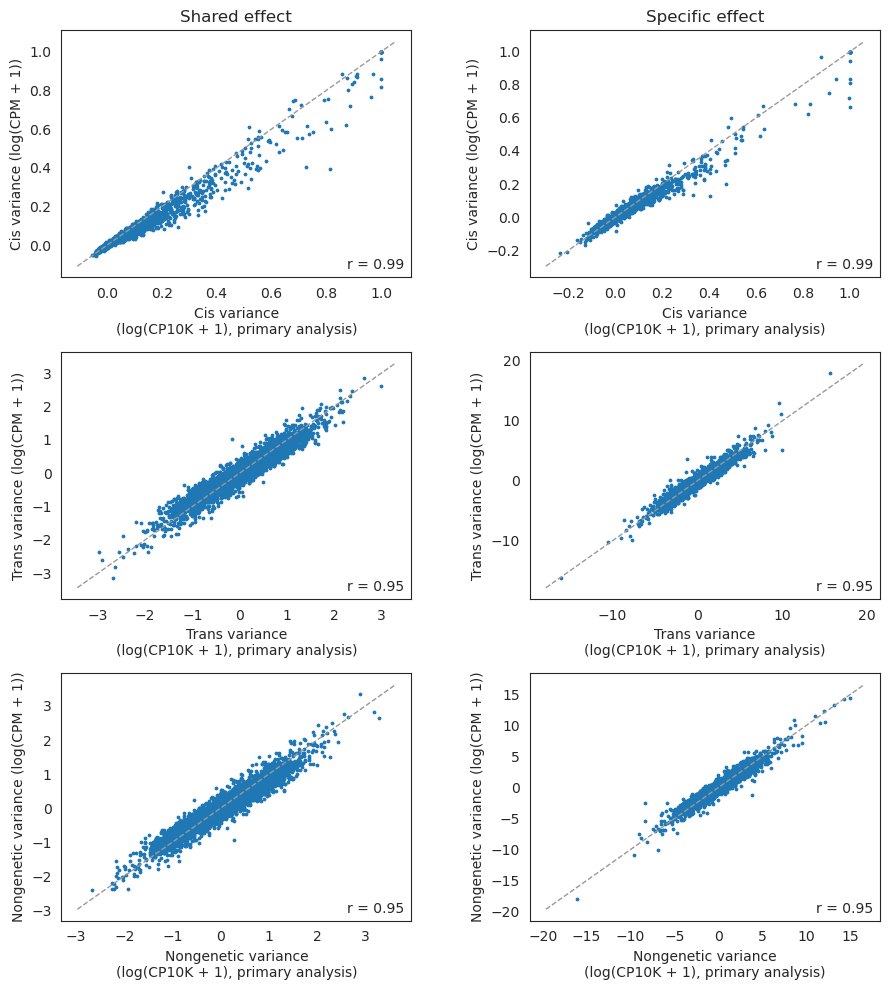

In [35]:
s = 12
lw = 1

# plot
fig, axes = plt.subplots(3, 2, figsize=(9, 10))

axes[0, 0].scatter(merge_cpm_df['hom_g2'].clip(np.nan, 1), merge_cpm_df['hom_g2_cpm'].clip(np.nan, 1.), marker='.', s=s)
# plot.scatter(merge_cpm_df['hom_g2'].clip(np.nan, 1), merge_cpm_df['hom_g2_cpm'].clip(np.nan, 1.), s=6, ax=axes[0, 0], heatscatter=True)
r, p = stats.pearsonr(merge_cpm_df['hom_g2'], merge_cpm_df['hom_g2_cpm'])
print(p)
axes[0, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 0].transAxes)

axes[0, 1].scatter(merge_cpm_df['V_bar'].clip(np.nan, 1), merge_cpm_df['V_bar_cpm'].clip(np.nan, 1.), marker='.', s=s)
# plot.scatter(merge_cpm_df['V_bar'].clip(np.nan, 1), merge_cpm_df['V_bar_cpm'].clip(np.nan, 1.), s=6, ax=axes[0, 1], heatscatter=True)
r, p = stats.pearsonr(merge_cpm_df['V_bar'], merge_cpm_df['V_bar_cpm'])
print(p)
axes[0, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 1].transAxes)

axes[1, 0].scatter(merge_cpm_df['hom_g2_b'], merge_cpm_df['hom_g2_b_cpm'], marker='.', s=s)
# plot.scatter(merge_cpm_df['hom_g2_b'], merge_cpm_df['hom_g2_b_cpm'], s=6, ax=axes[1, 0], heatscatter=True)
r, p = stats.pearsonr(merge_cpm_df['hom_g2_b'], merge_cpm_df['hom_g2_b_cpm'])
print(p)
axes[1, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[1, 0].transAxes)

axes[1, 1].scatter(merge_cpm_df['V_b_bar'], merge_cpm_df['V_b_bar_cpm'], marker='.', s=s)
# plot.scatter(merge_cpm_df['V_b_bar'], merge_cpm_df['V_b_bar_cpm'], s=6, ax=axes[1, 1], heatscatter=True)
r, p = stats.pearsonr(merge_cpm_df['V_b_bar'], merge_cpm_df['V_b_bar_cpm'])
print(p)
axes[1, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[1, 1].transAxes)

axes[2, 0].scatter(merge_cpm_df['hom_e2'], merge_cpm_df['hom_e2_cpm'], marker='.', s=s)
r, p = stats.pearsonr(merge_cpm_df['hom_e2'], merge_cpm_df['hom_e2_cpm'])
print(p)
axes[2, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[2, 0].transAxes)

axes[2, 1].scatter(merge_cpm_df['W_bar'], merge_cpm_df['W_bar_cpm'], marker='.', s=s)
r, p = stats.pearsonr(merge_cpm_df['W_bar'], merge_cpm_df['W_bar_cpm'])
print(p)
axes[2, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[2, 1].transAxes)


axes[0, 0].set_title('Shared effect')
axes[0, 1].set_title('Specific effect')

# x y labels
for ax in axes[0]:
    ax.set_xlabel('Cis variance\n(log(CP10K + 1), primary analysis)')
    ax.set_ylabel('Cis variance (log(CPM + 1))')
for ax in axes[1]:
    ax.set_xlabel('Trans variance\n(log(CP10K + 1), primary analysis)')
    ax.set_ylabel('Trans variance (log(CPM + 1))')
for ax in axes[2]:
    ax.set_xlabel('Nongenetic variance\n(log(CP10K + 1), primary analysis)')
    ax.set_ylabel('Nongenetic variance (log(CPM + 1))')


# y = x line
for ax in axes.flatten():
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    lims = [min(xlims[0], ylims[0]), max(xlims[1], ylims[1])]
    ax.plot(lims, lims, color='0.6', linestyle='--', lw=lw)

fig.tight_layout(w_pad=4)

# QC individuals

In [36]:
# joint_min20_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~20_prop~0.8_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/trans/he.npy'
# joint_min30_f = '../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~30_prop~0.6_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/trans/he.npy'

# joint_min20 = np.load(joint_min20_f, allow_pickle=True).item()
# joint_min30 = np.load(joint_min30_f, allow_pickle=True).item()

# # joint_min20
# joint_min20_data = {'gene': joint_min20['gene'], 
#                 'hom_g2': joint_min20['free']['hom_g2'], 'V_bar': np.mean(np.diagonal(joint_min20['free']['V'], axis1=1, axis2=2), axis=1),
#                 'hom_g2_b': joint_min20['free']['hom_g2_b'], 'V_b_bar': np.mean(np.diagonal(joint_min20['free']['V_b'], axis1=1, axis2=2), axis=1),
#                 'hom_e2': joint_min20['free']['hom_e2'], 'W_bar': np.mean(np.diagonal(joint_min20['free']['W'], axis1=1, axis2=2), axis=1),}
# joint_min20_df = pd.DataFrame(joint_min20_data)

# # joint_min30
# joint_min30_data = {'gene': joint_min30['gene'], 
#                 'hom_g2': joint_min30['free']['hom_g2'], 'V_bar': np.mean(np.diagonal(joint_min30['free']['V'], axis1=1, axis2=2), axis=1),
#                 'hom_g2_b': joint_min30['free']['hom_g2_b'], 'V_b_bar': np.mean(np.diagonal(joint_min30['free']['V_b'], axis1=1, axis2=2), axis=1),
#                 'hom_e2': joint_min30['free']['hom_e2'], 'W_bar': np.mean(np.diagonal(joint_min30['free']['W'], axis1=1, axis2=2), axis=1),}
# joint_min30_df = pd.DataFrame(joint_min30_data)

# # merge
# merge_min_df = trans_df.merge(joint_min20_df, on='gene', suffixes=('', '_min20')).merge(joint_min30_df, on='gene', suffixes=('', '_min30'))

In [37]:
# NOTE: not finished
# s = 3
# lw = 1

# # plot
# fig, axes = plt.subplots(5, 2, figsize=(8, 14))

# axes[0, 0].scatter(merge_min_df['hom_g2'], merge_min_df['hom_g2_min20'], marker='.', s=s)
# r, p = stats.pearsonr(merge_min_df['hom_g2'], merge_min_df['hom_g2_min20'])
# print(p)
# axes[0, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 0].transAxes)

# axes[0, 1].scatter(merge_min_df['V_bar'], merge_min_df['V_bar_min20'], marker='.', s=s)
# r, p = stats.pearsonr(merge_min_df['V_bar'], merge_min_df['V_bar_min20'])
# print(p)
# axes[0, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[0, 1].transAxes)

# axes[1, 0].scatter(merge_min_df['hom_g2'], merge_min_df['hom_g2_min30'], marker='.', s=s)
# r, p = stats.pearsonr(merge_min_df['hom_g2'], merge_min_df['hom_g2_min30'])
# print(p)
# axes[1, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[1, 0].transAxes)

# axes[1, 1].scatter(merge_min_df['V_bar'], merge_min_df['V_bar_min30'], marker='.', s=s)
# r, p = stats.pearsonr(merge_min_df['V_bar'], merge_min_df['V_bar_min30'])
# print(p)
# axes[1, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[1, 1].transAxes)

# axes[2, 0].scatter(merge_min_df['hom_g2_b'], merge_min_df['hom_g2_b_min20'], marker='.', s=s)
# r, p = stats.pearsonr(merge_min_df['hom_g2_b'], merge_min_df['hom_g2_b_min20'])
# print(p)
# axes[2, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[2, 0].transAxes)

# axes[2, 1].scatter(merge_min_df['V_b_bar'], merge_min_df['V_b_bar_min20'], marker='.', s=s)
# r, p = stats.pearsonr(merge_min_df['V_b_bar'], merge_min_df['V_b_bar_min20'])
# print(p)
# axes[2, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[2, 1].transAxes)

# axes[3, 0].scatter(merge_min_df['hom_g2_b'], merge_min_df['hom_g2_b_min30'], marker='.', s=s)
# r, p = stats.pearsonr(merge_min_df['hom_g2_b'], merge_min_df['hom_g2_b_min30'])
# print(p)
# axes[3, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[3, 0].transAxes)

# axes[3, 1].scatter(merge_min_df['V_b_bar'], merge_min_df['V_b_bar_min30'], marker='.', s=s)
# r, p = stats.pearsonr(merge_min_df['V_b_bar'], merge_min_df['V_b_bar_min30'])
# print(p)
# axes[3, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[3, 1].transAxes)

# axes[4, 0].scatter(merge_min_df['hom_e2'], merge_min_df['hom_e2_min30'], marker='.', s=s)
# r, p = stats.pearsonr(merge_min_df['hom_e2'], merge_min_df['hom_e2_min30'])
# print(p)
# axes[4, 0].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[4, 0].transAxes)

# axes[4, 1].scatter(merge_min_df['W_bar'], merge_min_df['W_bar_min30'], marker='.', s=s)
# r, p = stats.pearsonr(merge_min_df['W_bar'], merge_min_df['W_bar_min30'])
# print(p)
# axes[4, 1].text(0.98, 0.02, f'r = {r:.2f}', ha='right', va='bottom', transform=axes[4, 1].transAxes)


# axes[0, 0].set_title('Shared effect')
# axes[0, 1].set_title('Specific effect')

# axes[0, 0].set_xlabel('Cis variance (> 10 cells, primary analysis)')
# axes[0, 0].set_ylabel('Cis variance (> 20 cells)')
# axes[0, 1].set_xlabel('Cis variance (> 10 cells, primary analysis)')
# axes[0, 1].set_ylabel('Cis variance (> 20 cells)')

# axes[1, 0].set_xlabel('Cis variance (> 10 cells, primary analysis)')
# axes[1, 0].set_ylabel('Cis variance (> 30 cells)')
# axes[1, 1].set_xlabel('Cis variance (> 10 cells, primary analysis)')
# axes[1, 1].set_ylabel('Cis variance (> 30 cells)')

# axes[2, 0].set_xlabel('Trans variance (> 10 cells, primary analysis)')
# axes[2, 0].set_ylabel('Trans variance (> 20 cells)')
# axes[2, 1].set_xlabel('Trans variance (> 10 cells, primary analysis)')
# axes[2, 1].set_ylabel('Trans variance (> 20 cells)')

# axes[3, 0].set_xlabel('Trans variance (> 10 cells, primary analysis)')
# axes[3, 0].set_ylabel('Trans variance (> 30 cells)')
# axes[3, 1].set_xlabel('Trans variance (> 10 cells, primary analysis)')
# axes[3, 1].set_ylabel('Trans variance (> 30 cells)')

# axes[4, 0].set_xlabel('Nongenetic variance (> 10 cells, primary analysis)')
# axes[4, 0].set_ylabel('Nongenetic variance (> 30 cells)')
# axes[4, 1].set_xlabel('Nongenetic variance (> 10 cells, primary analysis)')
# axes[4, 1].set_ylabel('Nongenetic variance (> 30 cells)')


# # y = x line
# for ax in axes.flatten():
#     xlims = ax.get_xlim()
#     ylims = ax.get_ylim()
#     lims = [min(xlims[0], ylims[0]), max(xlims[1], ylims[1])]
#     ax.plot(lims, lims, color='0.6', linestyle='--', lw=lw)

# fig.tight_layout(w_pad=4)

# Variance decomposition

## cis

In [38]:
# nu = pd.read_table('../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/nu.final.gz', index_col=0)[cis['gene']]
# ctnu = pd.read_table('../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/ctnu.final.gz', index_col=0)[cis['gene']]
# assert np.all(cis['gene'] == nu.columns.to_numpy()) and np.all(cis['gene'] == ctnu.columns.to_numpy())

# N, C = P.shape

# # OP variance components
# op_data = {
#     'Batch': cis['free']['op_random_vars']['batch'],
#     'Cell Type Mean': cis['free']['op_fixed_vars']['ct_beta'], 
#     'Overall Pseudobulk PC': cis['free']['op_fixed_vars']['op_pca'],
#     'Sex': cis['free']['op_fixed_vars']['sex'],
#     'Age':cis['free']['op_fixed_vars']['age'],
#     'Genotype PC': cis['free']['op_fixed_vars']['geno_pca'],
#     'Shared Genetics': cis['free']['hom_g2'],
#     'Shared Nongenetics': cis['free']['hom_e2'],
#     'Specific Genetics': np.trace(cis['free']['V'] @ (P.values.T @ P.values), axis1=1, axis2=2) / N,
#     'Specific Nongenetics': np.trace(cis['free']['W'] @ (P.values.T @ P.values), axis1=1, axis2=2) / N,
#     'Cell Noise': nu.mean().to_numpy(),
#     }

# op_df = pd.DataFrame(op_data, index=cis['gene'])

# # total op variance
# op_df['Total'] = op_df.sum(axis=1)

In [39]:
# means = op_df.mean()
# orders = means.sort_values().index.to_numpy()
# fixed = ['Cell Type Mean', 'Overall Pseudobulk PC', 'Sex', 'Age', 'Genotype PC']
# orders = orders[np.isin(orders, fixed)].tolist() + orders[~np.isin(orders, fixed)].tolist()

# # plot
# fig, ax = plt.subplots(figsize=(10, 5))

# sns.boxplot(data=op_df, ax=ax, fliersize=2, order=orders)

# ax.axhline(y=1, color='r', linestyle='--')
# ax.axhline(y=0, color='.7', linestyle='--', zorder=0)

# # move x labels down
# ax.set_xticks(ax.get_xticks())
# ax.set_xticklabels([f'{label.get_text()}     ' for label in ax.get_xticklabels()])
# # add means
# y = -1.7
# ax.text(-1, y, 'Mean:', fontweight='bold', va='bottom')
# for x, mean in zip(ax.get_xticks(), means[orders]):
#     ax.text(x, y, f'{mean:.3f}', ha='center', va='bottom')

# # ax.set_xlabel('Component')
# ax.set_ylabel('Explained OP Variance')

# ax.tick_params(axis='x', rotation=90)

# fig.tight_layout()

## trans

Number of genes: (8701, 28)
OP h2: 0.055235948904285986 0.003120003857523127 0.24420587714315908 0.049798733231837554
Specific h2 in cis: 0.05346504872018823
Proportion of trans h2: 0.8343856865186354
CTP h2 0.023324418431451124 0.01053416488558596 0.10136985303533792 0.14757056402942126
Specific h2 in cis 0.31112243495094316
Proportion of trans h2: 0.8802733274469644
CTP - OP trans proportion: 0.04588764092832898
Permutation p: 0.005


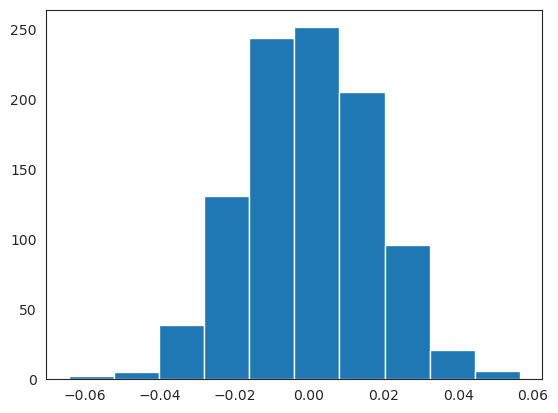

In [40]:
nu = pd.read_table('../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/nu.final.gz', index_col=0)[cis['gene']]
ctnu = pd.read_table('../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/ctnu.final.gz', index_col=0)[cis['gene']]
assert np.all(trans['gene'] == nu.columns.to_numpy()) and np.all(trans['gene'] == ctnu.columns.to_numpy())

N, C = P.shape

# OP variance components
trans_op_data = {
    'Batch': trans['free']['op_random_vars']['batch'],
    'Cell Type Mean': trans['free']['op_fixed_vars']['ct_beta'], 
    'Overall Pseudobulk PC': trans['free']['op_fixed_vars']['op_pca'],
    'Sex': trans['free']['op_fixed_vars']['sex'],
    'Age':trans['free']['op_fixed_vars']['age'],
    'Genotype PC': trans['free']['op_fixed_vars']['geno_pca'],
    'Shared Genetics (cis)': trans['free']['hom_g2'],
    'Shared Nongenetics': trans['free']['hom_e2'],
    'Specific Genetics (cis)': np.trace(trans['free']['V'] @ (P.values.T @ P.values), axis1=1, axis2=2) / N,
    'Specific Nongenetics': np.trace(trans['free']['W'] @ (P.values.T @ P.values), axis1=1, axis2=2) / N,
    'Shared Genetics (trans)': trans['free']['hom_g2_b'],
    'Specific Genetics (trans)': np.trace(trans['free']['V_b'] @ (P.values.T @ P.values), axis1=1, axis2=2) / N,
    'Cell Noise': nu.mean().to_numpy(),
    }


trans_op_df = pd.DataFrame(trans_op_data, index=cis['gene'])

# total op variance
trans_op_df['Total'] = trans_op_df.sum(axis=1)

# print(f"Proportion of specific in cis: {trans_op_df['Specific Genetics (cis)'].mean() / (trans_op_df['Specific Genetics (cis)'].mean() + trans_op_df['Shared Genetics (cis)'].mean())}")
# print(f"Proportion of specific in trans: {trans_op_df['Specific Genetics (trans)'].mean() / (trans_op_df['Specific Genetics (trans)'].mean() + trans_op_df['Shared Genetics (trans)'].mean())}")
# print(f"Proportion of trans: {(trans_op_df['Specific Genetics (trans)'] + trans_op_df['Shared Genetics (trans)']).mean() / (trans_op_df['Specific Genetics (trans)'] + trans_op_df['Shared Genetics (trans)'] + trans_op_df['Specific Genetics (cis)'] + trans_op_df['Shared Genetics (cis)']).mean()}")

# add gene
trans_op_df['gene'] = trans['gene']

# add CTP variance
trans_op_df['v_bar'] = np.diagonal(trans['free']['V'], axis1=1, axis2=2).mean(axis=1)
trans_op_df['v_bar (trans)'] = np.diagonal(trans['free']['V_b'], axis1=1, axis2=2).mean(axis=1)
trans_op_df['w_bar'] = np.diagonal(trans['free']['W'], axis1=1, axis2=2).mean(axis=1)

# OP h2
trans_op_df['total variance'] = (trans_op_df['Shared Genetics (cis)'] + trans_op_df['Specific Genetics (cis)'] 
                            + trans_op_df['Shared Genetics (trans)'] + trans_op_df['Specific Genetics (trans)']
                            + trans_op_df['Shared Nongenetics'] + trans_op_df['Specific Nongenetics'])

trans_op_df['Shared h2 (cis)'] = trans_op_df['Shared Genetics (cis)'] / trans_op_df['total variance']
trans_op_df['Specific h2 (cis)'] = trans_op_df['Specific Genetics (cis)'] / trans_op_df['total variance']
trans_op_df['Shared h2 (trans)'] = trans_op_df['Shared Genetics (trans)'] / trans_op_df['total variance']
trans_op_df['Specific h2 (trans)'] = trans_op_df['Specific Genetics (trans)'] / trans_op_df['total variance']

# CTP h2
trans_op_df['ctp total variance'] = (trans_op_df['Shared Genetics (cis)'] + trans_op_df['v_bar'] 
                            + trans_op_df['Shared Genetics (trans)'] + trans_op_df['v_bar (trans)']
                            + trans_op_df['Shared Nongenetics'] + trans_op_df['w_bar'])

trans_op_df['ctp Shared h2 (cis)'] = trans_op_df['Shared Genetics (cis)'] / trans_op_df['ctp total variance']
trans_op_df['ctp Specific h2 (cis)'] = trans_op_df['v_bar'] / trans_op_df['ctp total variance']
trans_op_df['ctp Shared h2 (trans)'] = trans_op_df['Shared Genetics (trans)'] / trans_op_df['ctp total variance']
trans_op_df['ctp Specific h2 (trans)'] = trans_op_df['v_bar (trans)'] / trans_op_df['ctp total variance']

# filter
filtered_trans_op_df = trans_op_df.loc[(trans_op_df['total variance'] > 0) & (trans_op_df['ctp total variance'] > 0)]
print('Number of genes:', filtered_trans_op_df.shape)

# proportion of h2
median_shared_h2_cis = filtered_trans_op_df['Shared h2 (cis)'].median()
median_specific_h2_cis = filtered_trans_op_df['Specific h2 (cis)'].median()
median_shared_h2_trans = filtered_trans_op_df['Shared h2 (trans)'].median()
median_specific_h2_trans = filtered_trans_op_df['Specific h2 (trans)'].median()
median_h2_cis = median_shared_h2_cis + median_specific_h2_cis
median_h2_trans = median_shared_h2_trans + median_specific_h2_trans

print('OP h2:', median_shared_h2_cis, median_specific_h2_cis, median_shared_h2_trans, median_specific_h2_trans)

print('Specific h2 in cis:', median_specific_h2_cis / median_h2_cis)
# print(median_specific_h2_trans / median_h2_trans)
trans_prop = median_h2_trans / (median_h2_cis + median_h2_trans)
print('Proportion of trans h2:', trans_prop)

## proportion of ctp h2
median_ctp_shared_h2_cis = filtered_trans_op_df['ctp Shared h2 (cis)'].median()
median_ctp_specific_h2_cis = filtered_trans_op_df['ctp Specific h2 (cis)'].median()
median_ctp_shared_h2_trans = filtered_trans_op_df['ctp Shared h2 (trans)'].median()
median_ctp_specific_h2_trans = filtered_trans_op_df['ctp Specific h2 (trans)'].median()
median_ctp_h2_cis = median_ctp_shared_h2_cis + median_ctp_specific_h2_cis
median_ctp_h2_trans = median_ctp_shared_h2_trans + median_ctp_specific_h2_trans

print('CTP h2', median_ctp_shared_h2_cis, median_ctp_specific_h2_cis, median_ctp_shared_h2_trans, median_ctp_specific_h2_trans)

print('Specific h2 in cis', median_ctp_specific_h2_cis / median_ctp_h2_cis)
ctp_trans_prop = median_ctp_h2_trans / (median_ctp_h2_cis + median_ctp_h2_trans)
print('Proportion of trans h2:', ctp_trans_prop)

prop_diff = ctp_trans_prop - trans_prop
print('CTP - OP trans proportion:', prop_diff)

# permutation
rng = np.random.default_rng(123)
def cal_trans_prop(shared_cis, specific_cis, shared_trans, specific_trans): 
    shared_cis_median = np.median(shared_cis)
    specific_cis_median = np.median(specific_cis)
    shared_trans_median = np.median(shared_trans)
    specific_trans_median = np.median(specific_trans)
    cis_median = shared_cis_median + specific_cis_median
    trans_median = shared_trans_median + specific_trans_median

    return trans_median / (cis_median + trans_median)

combined = np.vstack([
    filtered_trans_op_df[['Shared h2 (cis)', 'Specific h2 (cis)', 'Shared h2 (trans)', 'Specific h2 (trans)']].values,
    filtered_trans_op_df[['ctp Shared h2 (cis)', 'ctp Specific h2 (cis)', 'ctp Shared h2 (trans)', 'ctp Specific h2 (trans)']].values,
])
k = 999
prop_diffs = []
for i in range(k):
    rng.shuffle(combined)
    op_perm = combined[:filtered_trans_op_df.shape[0]]
    ctp_perm = combined[filtered_trans_op_df.shape[0]:]
    op_prop = cal_trans_prop(op_perm[:, 0], op_perm[:, 1], op_perm[:, 2], op_perm[:, 3])
    ctp_prop = cal_trans_prop(ctp_perm[:, 0], ctp_perm[:, 1], ctp_perm[:, 2], ctp_perm[:, 3])
    prop_diffs.append(ctp_prop - op_prop)

prop_diffs = np.array(prop_diffs)
p = (1 + (prop_diffs > prop_diff).sum()) / (k + 1)
print('Permutation p:', p)
plt.hist(prop_diffs)

## confidence interval
median_shared_h2_cis_ci = stats.bootstrap((filtered_trans_op_df['Shared h2 (cis)'],), np.median, 
                                          vectorized=False, random_state=rng).confidence_interval
median_specific_h2_cis_ci = stats.bootstrap((filtered_trans_op_df['Specific h2 (cis)'],), np.median, 
                                          vectorized=False, random_state=rng).confidence_interval
median_shared_h2_trans_ci = stats.bootstrap((filtered_trans_op_df['Shared h2 (trans)'],), np.median, 
                                          vectorized=False, random_state=rng).confidence_interval
median_specific_h2_trans_ci = stats.bootstrap((filtered_trans_op_df['Specific h2 (trans)'],), np.median, 
                                          vectorized=False, random_state=rng).confidence_interval


In [41]:
for f in ['ratio of means', 'mean of ratios']:
    print(f)
    if f == 'mean of ratios':
        # op h2
        f_shared_h2_cis = filtered_trans_op_df['Shared h2 (cis)'].mean()
        f_specific_h2_cis = filtered_trans_op_df['Specific h2 (cis)'].mean()
        f_shared_h2_trans = filtered_trans_op_df['Shared h2 (trans)'].mean()
        f_specific_h2_trans = filtered_trans_op_df['Specific h2 (trans)'].mean()
        f_h2_cis = f_shared_h2_cis + f_specific_h2_cis
        f_h2_trans = f_shared_h2_trans + f_specific_h2_trans

        # ctp h2
        f_ctp_shared_h2_cis = filtered_trans_op_df['ctp Shared h2 (cis)'].mean()
        f_ctp_specific_h2_cis = filtered_trans_op_df['ctp Specific h2 (cis)'].mean()
        f_ctp_shared_h2_trans = filtered_trans_op_df['ctp Shared h2 (trans)'].mean()
        f_ctp_specific_h2_trans = filtered_trans_op_df['ctp Specific h2 (trans)'].mean()
        f_ctp_h2_cis = f_ctp_shared_h2_cis + f_ctp_specific_h2_cis
        f_ctp_h2_trans = f_ctp_shared_h2_trans + f_ctp_specific_h2_trans
    
    elif f == 'ratio of means':
        # op h2
        f_shared_h2_cis = filtered_trans_op_df['Shared Genetics (cis)'].mean() / filtered_trans_op_df['total variance'].mean()
        f_specific_h2_cis = filtered_trans_op_df['Specific Genetics (cis)'].mean() / filtered_trans_op_df['total variance'].mean()
        f_shared_h2_trans = filtered_trans_op_df['Shared Genetics (trans)'].mean() / filtered_trans_op_df['total variance'].mean()
        f_specific_h2_trans = filtered_trans_op_df['Specific Genetics (trans)'].mean() / filtered_trans_op_df['total variance'].mean()
        f_h2_cis = f_shared_h2_cis + f_specific_h2_cis
        f_h2_trans = f_shared_h2_trans + f_specific_h2_trans

        # ctp h2
        f_ctp_shared_h2_cis = filtered_trans_op_df['Shared Genetics (cis)'].mean() / filtered_trans_op_df['ctp total variance'].mean()
        f_ctp_specific_h2_cis = filtered_trans_op_df['v_bar'].mean() / filtered_trans_op_df['ctp total variance'].mean()
        f_ctp_shared_h2_trans = filtered_trans_op_df['Shared Genetics (trans)'].mean() / filtered_trans_op_df['ctp total variance'].mean()
        f_ctp_specific_h2_trans = filtered_trans_op_df['v_bar (trans)'].mean() / filtered_trans_op_df['ctp total variance'].mean()
        f_ctp_h2_cis = f_ctp_shared_h2_cis + f_ctp_specific_h2_cis
        f_ctp_h2_trans = f_ctp_shared_h2_trans + f_ctp_specific_h2_trans
    

    print('OP h2:', f_shared_h2_cis, f_specific_h2_cis, 
        f_shared_h2_trans, f_specific_h2_trans)

    print('Specific h2 in cis:', f_specific_h2_cis / f_h2_cis)
    trans_prop = f_h2_trans / (f_h2_cis + f_h2_trans)
    print('Proportion of trans h2:', trans_prop)

    print('CTP h2', f_ctp_shared_h2_cis, f_ctp_specific_h2_cis, 
        f_ctp_shared_h2_trans, f_ctp_specific_h2_trans)

    print('Specific h2 in cis', f_ctp_specific_h2_cis / f_ctp_h2_cis)
    ctp_trans_prop = f_ctp_h2_trans / (f_ctp_h2_cis + f_ctp_h2_trans)
    print('Proportion of trans h2:', ctp_trans_prop)

    prop_diff = ctp_trans_prop - trans_prop
    print('CTP - OP trans proportion:', prop_diff)


# # genetic variance  # results is the same as ratio of means in h2
# print('Genetic variance')
# # op
# f_shared_variance_cis = filtered_trans_op_df['Shared Genetics (cis)'].mean()
# f_specific_variance_cis = filtered_trans_op_df['Specific Genetics (cis)'].mean()
# f_shared_variance_trans = filtered_trans_op_df['Shared Genetics (trans)'].mean()
# f_specific_variance_trans = filtered_trans_op_df['Specific Genetics (trans)'].mean()
# f_variance_cis = f_shared_variance_cis + f_specific_variance_cis
# f_variance_trans = f_shared_variance_trans + f_specific_variance_trans

# # ctp
# f_ctp_shared_variance_cis = filtered_trans_op_df['Shared Genetics (cis)'].mean()
# f_ctp_specific_variance_cis = filtered_trans_op_df['v_bar'].mean()
# f_ctp_shared_variance_trans = filtered_trans_op_df['Shared Genetics (trans)'].mean()
# f_ctp_specific_variance_trans = filtered_trans_op_df['v_bar (trans)'].mean()
# f_ctp_variance_cis = f_ctp_shared_variance_cis + f_ctp_specific_variance_cis
# f_ctp_variance_trans = f_ctp_shared_variance_trans + f_ctp_specific_variance_trans


# print('OP variance:', f_shared_variance_cis, f_specific_variance_cis, 
#     f_shared_variance_trans, f_specific_variance_trans)

# print('Specific variance in cis:', f_specific_variance_cis / f_variance_cis)
# trans_prop = f_variance_trans / (f_variance_cis + f_variance_trans)
# print('Proportion of trans variance:', trans_prop)

# print('CTP variance', f_ctp_shared_variance_cis, f_ctp_specific_variance_cis, 
#     f_ctp_shared_variance_trans, f_ctp_specific_variance_trans)

# print('Specific variance in cis', f_ctp_specific_variance_cis / f_ctp_variance_cis)
# ctp_trans_prop = f_ctp_variance_trans / (f_ctp_variance_cis + f_ctp_variance_trans)
# print('Proportion of trans variance:', ctp_trans_prop)

# prop_diff = ctp_trans_prop - trans_prop
# print('CTP - OP trans proportion:', prop_diff)

ratio of means
OP h2: 0.2127832850185126 0.015068602735680304 0.23811127094236162 0.04689868370817187
Specific h2 in cis: 0.0661333240826003
Proportion of trans h2: 0.55572462422661
CTP h2 0.08568175490439632 0.04547921659152925 0.09588061183980093 0.11715282467038964
Specific h2 in cis 0.3467435173194187
Proportion of trans h2: 0.6189334618893783
CTP - OP trans proportion: 0.0632088376627683
mean of ratios
OP h2: 0.49174371121776883 0.09088734442993499 2.925491794503591 -0.4312702408571116
Specific h2 in cis: 0.15599467887769325
Proportion of trans h2: 0.8106405702087378
CTP h2 0.15192839303100028 0.051908380448978164 0.31377329582847036 0.8338155756413952
Specific h2 in cis 0.25465660372649485
Proportion of trans h2: 0.8491690798959617
CTP - OP trans proportion: 0.03852850968722388


[[0.0029514  0.00438097]
 [0.04941146 0.06204012]]
[0.05523595 0.24420588] [0.00312    0.04979873]


/tmp/ipykernel_1001/3092803115.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


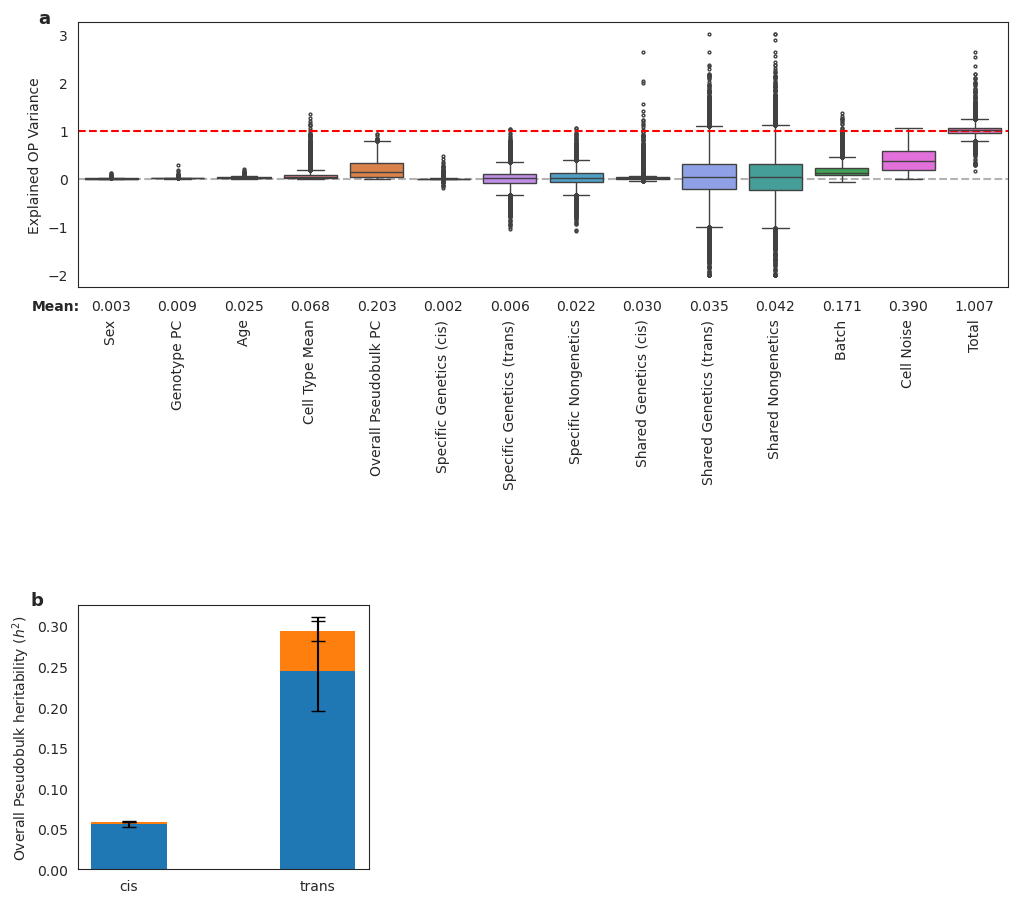

In [42]:
trans_fixed = ['Cell Type Mean', 'Overall Pseudobulk PC', 'Sex', 'Age', 'Genotype PC']
trans_random = ['Batch', 'Shared Genetics (cis)', 'Shared Nongenetics', 'Specific Genetics (cis)', 
                'Specific Nongenetics', 'Shared Genetics (trans)', 'Specific Genetics (trans)', 'Cell Noise']
trans_variances = trans_fixed + trans_random + ['Total']
trans_op_var_df = trans_op_df[trans_variances]
trans_means = trans_op_var_df.mean()
trans_orders = trans_means.sort_values().index.to_numpy()
trans_orders = trans_orders[np.isin(trans_orders, trans_fixed)].tolist() + trans_orders[~np.isin(trans_orders, trans_fixed)].tolist()

# plot
fig = plt.figure(1, figsize=(12, 11))
gs = gridspec.GridSpec(3, 3, wspace=.1, hspace=.1)

ax = fig.add_subplot(gs[:1, :])

sns.boxplot(data=trans_op_var_df.clip(-2, 3), ax=ax, fliersize=2, order=trans_orders)

ax.axhline(y=1, color='r', linestyle='--')
ax.axhline(y=0, color='.7', linestyle='--', zorder=0)

# move x labels down
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([f'{label.get_text()}     ' for label in ax.get_xticklabels()])
# add means
y = -2.8
ax.text(-1.2, y, 'Mean:', fontweight='bold', va='bottom')
for x, mean in zip(ax.get_xticks(), trans_means[trans_orders]):
    ax.text(x, y, f'{mean:.3f}', ha='center', va='bottom')

# ax.set_xlabel('Component')
ax.set_ylabel('Explained OP Variance')

ax.tick_params(axis='x', rotation=90)
ax.text(-0.03, 1.05, 'a', transform=ax.transAxes, fontsize=fs + 4, fontweight='bold', va='top', ha='right')

# plot proportion of h2
width = .4
labels = ['cis', 'trans']
ax = fig.add_subplot(gs[2, 0])

bottom = np.zeros(2)
values = np.array([median_shared_h2_cis, median_shared_h2_trans]) 
ci = np.array([median_shared_h2_cis_ci, median_shared_h2_trans_ci]) 
yerr = np.abs(ci - values[:, np.newaxis])
print(yerr)

ax.bar(labels, values, width, yerr=yerr.T, capsize=5,
    bottom=bottom, color=colors[0], edgecolor='none', label='Shared')

bottom += [median_shared_h2_cis, median_shared_h2_trans]
values = np.array([median_specific_h2_cis, median_specific_h2_trans])
print(bottom, values)
ci = np.array([median_specific_h2_cis_ci, median_specific_h2_trans_ci])
yerr = np.abs(ci - values[:, np.newaxis])
ax.bar(labels, values, width, yerr=yerr.T, capsize=5,
        bottom=bottom, color=colors[1], edgecolor='none', label='Specific')

ax.set_ylabel('Overall Pseudobulk heritability ($h^2$)')
ax.text(-0.12, 1.05, 'b', transform=ax.transAxes, fontsize=fs + 4, fontweight='bold', va='top', ha='right')


fig.tight_layout()